## Identificikacia odhlahlych hodnot v datach zo sledovania pohladu

###### Validacia
1. Odfitrovanie participantov na zaklade kalibracie (bud zo zaciatku, alebo aj zo zaciatku a konca - pricom sa porovnava s priemerom a medzi zaciatkom a koncom)
2. Odfiltrovanie participantov na zaklade validacie oci a dat (<= validity code a percento validnych dat podla kodu)
------------
###### Preprocessing 
1. V casti preprocesingu vytiahnem len data ktore sa tykaju ulohy a kedy sa zacalo natacat (takze ide prec instrukcie a nakonci dotaznik)
2. Odfiltrujem duplicitne fixacie (teda gazepointy ktore tvoria fixacie a vyhodim take kde je niektore z bodu fixacie (x,y) Nan = Null)
3. Vypocitam si aoi pre ulohu na zaklade koordinatov (vyuzivam kniznicu shapely) 

##### Features
Crty odvodene od: 
1. Fixacii
2. Sakad 
3. RQA
4. DTW

---------------------------------------------------

##### Experts:
['tester11', 'tester38', 'tester39', 'tester42', 'tester49', 'tester60', 'tester61', 'tester65', 'tester68'] 
<br/>Pocet: 9

##### Novices:
['tester08', 'tester22', 'tester34', 'tester35', 'tester36', 'tester40', 'tester41', 'tester44', 'tester46', 'tester48', 'tester52', 'tester57', 'tester69']
<br/>Pocet: 13

In [1]:
%matplotlib notebook

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import glob
import string
import itertools
#Included metrics are Levenshtein, Hamming, Jaccard, and Sorensen distance, plus some bonuses
import distance
import math

# From configuration file
from configparser import ConfigParser
import codecs

import collections

from fastdtw import fastdtw # Dynamic time warping
from IPython.display import clear_output
# Shapely - for points and polygons (AOIS)
from shapely.geometry import Point, Polygon

# Distances
from scipy.spatial.distance import *
from scipy import stats

# Machine learning and clustering scitic
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples, silhouette_score 
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import preprocessing # predspracovanie dat - scale
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

# Custom modules
from data_validation import data_validation_filter as dvf
from data_processing import aoi as ac
from data_processing import data_preprocessing as dp

# RQA
from algorithms.RQA import DynamicalSystemsModule as RecurrenceFunctions
from algorithms.RQA import SpatioTemporalEyeTrackingModule as ReoccurrenceFunctions

# Clustering from pyclustering
import pyclustering.cluster.dbscan as cluster
import pyclustering.cluster.kmedoids as kmedoid

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

___________________________________
### Global variables

In [2]:
TASKS = {
    "1":["IE_1.tsv", "1.txt"],
    "2":["IE_2.tsv", "2.txt"],
    "3":["IE_3.tsv", "3.txt"],
    "4":["IE_4.tsv", "4.txt"],
    "5":["IE_5.tsv", "5.txt"],
    "6":["IE_6.tsv", "6.txt"],
    "7":["IE_7.tsv", "7.txt"],
    "8":["IE_8.tsv", "8.txt"]
}
TASK_DATA_NAMES = ["IE_1", "IE_2", "IE_3", "IE_4", "IE_5", "IE_6", "IE_7", "IE_1"]
AOI_DATA_NAMES = ["1.txt","2.txt","3.txt","4.txt","5.txt","6.txt","7.txt","8.txt"]
STUDIO_EVENTS = ['InstructionStart', 'InstructionEnd', 'ScreenRecStarted', 'URLStart', 
                 'URLEnd', 'ScreenRecStopped', 'QuestionStarted','QuestionEnded']

COLORS = ["cyan", "yellow","red","blue", "green","magenta","black","white"]

#columns_to_drop = ['Name','Scanpath','ScanpathShort','FixationsDuration', 'MaxLev', 'MinLev', 'MaxLcs', 'MinLcs', 'ReoccurrenceRate', 'AverageSaccadeLength']
COLUMNS_TO_DROP_0 = ['Name','Scanpath','ScanpathShort']

# Load configuration file
CONFIG_PARSER = ConfigParser()
with codecs.open('config.ini', 'r', encoding='utf-8') as f:
    CONFIG_PARSER.read_file(f)


__________________________
### Class and functions

In [3]:
class Participant:
    
    def __init__(self, name):
        self.data = {}
        self.data["Name"] = name
        self.data["Scanpath"] = ""
        self.data["ScanpathShort"] = ""
        self.data["NumberOfAoisHits"] = 0
        self.data["NumberOfAoisHitsShort"] = 0
        
        self.data["NumberOfFixations"] = 0
        self.data["FixationsDuration"] = 0
        self.data["AverageFixationDuration"] = 0
        
        # Saccades
        # Average
        self.data["AverageSaccadeSpeed"] = 0
        # Average
        self.data["AverageSaccadeLength"] = 0
        
        #RQA
        # Reoccurrence
        self.data["Reoccurrence"] = 0
        self.data["ReoccurrenceRate"] = 0
        self.data["ReoccurrenceDeterminism"] = 0
        self.data["ReoccurrenceLaminarity"] = 0
        self.data["ReoccurrenceCORM"] = 0
        # Recurrence
        self.data["Recurrence"] = 0
        self.data["RecurrenceRate"] = 0
        self.data["RecurrenceMeanX"] = 0
        self.data["RecurrenceMeanY"] = 0
        self.data["RecurrenceStandardDeviationX"] = 0
        self.data["RecurrenceStandardDeviationY"] = 0
        
        #DTW - Dynamic time warping average score (comparing to each scanpatch exlude itself)
        self.data["DTW"] = 0
        
        # LCS, LEV - Longest common subsequence, levensthein distance
        self.data["MaxLcs"] = 0
        self.data["MeanLcs"] = 0
        self.data["MinLcs"] = 0
        
        self.data["MaxLev"] = 0
        self.data["MeanLev"] = 0
        self.data["MinLev"] = 0
        
        
        #self.data["OutlierScore"] = 0
        
        # For RQA
        self.fixations = []
        self.fixationsToAoi = []
        self.outlierScore = 0
        self.completeTask = False
        self.passCalibration = False
        self.passValidation = False
        self.hasEnoughData = False

        
    def set_data(self, key, value):
        self.data[key] = value

In [24]:
def clusters_to_labels(X, clusters, noise = []):
    labels = [0] * len(X)
    for nois in noise:
        labels[nois] = -1
        
    i = 0  
    for one_cluster in clusters:
        for one in one_cluster:
            labels[one] = i
        i += 1
    
    return np.array(labels, dtype="int64")


def pair_labels_with_participants_dict(labels, df_names):
    participants_labels = {}
    i = 0
    for i in range(0,len(df_names)):
        participants_labels[df_names[i]] = round(labels[i], 3)
    return participants_labels

def pair_scores_with_participants(scores, df_names):
    participants_scores = []
    #i = 0
    for i in range(0,len(df_names)):
        participants_scores.append([df_names[i], round(scores[i], 3)])
    return participants_scores

def pair_multiple_scores_with_participants(scores, df_names):
    scores_together = np.zeros((len(df_names),len(scores)))
    participants_scores = []
    for i in range(0, len(scores)):
        for j in range(0, len(scores[i])):
            scores_together[j][i] = round(scores[i][j],3)

    for l in range(0, len(df_names)):
        participants_scores.append([df_names[l], scores_together[l]])
         
    return participants_scores

def pair_labels_with_participants(labels, df_names):
    participants_labels = []
    i = 0
    for i in range(0,len(df_names)):
        participants_labels.append([df_names[i], labels[i]])
    return participants_labels


def get_participants_with_label(labels, label, testers_names):
    indexes = np.where(labels == label)[0]
    return list(map(lambda i: ALL_PARTICIPANTS[testers_names[i]], indexes))


def transform_data(data):
    data_array = []
    for d in data:
        data_array.append(d.data)
        
    return data_array


def outliers_nd_sd(X_scores, paired_scores):
# https://www.kdnuggets.com/2017/02/removing-outliers-standard-deviation-python.html
# http://colingorrie.github.io/outlier-detection.html
    final_list = []
    final_list_temp = []
    outliers = []
    mean = np.mean(X_scores, axis=0)
    sd = np.std(X_scores, axis=0)

    #final_list = [x for x in paired_labels_orig if (x[1] > mean - 2 * sd)]
    for x in paired_scores:
        if(x[1] > mean - 2 * sd):
            final_list_temp.append(x)
        else:
            outliers.append(x)
    #final_list = [x for x in final_list if (x[1] < mean + 2 * sd)]
    for x in final_list_temp:
        if(x[1] < mean + 2 * sd):
            final_list.append(x)
        else:
            outliers.append(x)
            
    return outliers

def outliers_z_score(ys):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)

def loopRange(start, end):
    return range(start, end+1)

## Features
_________________________

### LCS 
Longest common subsequence - z dvoch stringov najde najdlhsu podpostupnost (to znamena, ze neberie do uvahy "noisy" znaky)

In [4]:
def lcs(a, b):
    lengths = [[0 for j in range(len(b)+1)] for i in range(len(a)+1)]
    # row 0 and column 0 are initialized to 0 already
    for i, x in enumerate(a):
        for j, y in enumerate(b):
            if x == y:
                lengths[i+1][j+1] = lengths[i][j] + 1
            else:
                lengths[i+1][j+1] = max(lengths[i+1][j], lengths[i][j+1])
    # read the substring out from the matrix
    result = ""
    x, y = len(a), len(b)
    while x != 0 and y != 0:
        if lengths[x][y] == lengths[x-1][y]:
            x -= 1
        elif lengths[x][y] == lengths[x][y-1]:
            y -= 1
        else:
            assert a[x-1] == b[y-1]
            result = a[x-1] + result
            x -= 1
            y -= 1
    return result

def get_LCS_features(participant, all_participants_features_names):
    lcs_values = []
    for tester in all_participants_features_names:
        if(tester != participant):
            lcs_values.append(len(lcs(ALL_PARTICIPANTS[participant].data["ScanpathShort"], ALL_PARTICIPANTS[tester].data["ScanpathShort"])))
    
    scanpath_len = len(ALL_PARTICIPANTS[participant].data["ScanpathShort"])
    lcs_max = np.max(lcs_values) / scanpath_len
    lcs_mean = np.mean(lcs_values) / scanpath_len
    lcs_min = np.min(lcs_values) / scanpath_len
    
    ALL_PARTICIPANTS[participant].set_data("MaxLcs", lcs_max)
    ALL_PARTICIPANTS[participant].set_data("MeanLcs", lcs_mean)
    ALL_PARTICIPANTS[participant].set_data("MinLcs", lcs_min)
    

### Levensthein

In [5]:
def get_LEV_features(participant, all_participants_features_names):
    lev_values = []
    for tester in all_participants_features_names:
        if(tester != participant):
            lev_values.append(distance.levenshtein(ALL_PARTICIPANTS[participant].data["ScanpathShort"], ALL_PARTICIPANTS[tester].data["ScanpathShort"]))
    
    scanpath_len = len(ALL_PARTICIPANTS[participant].data["ScanpathShort"])
    lev_max = np.max(lev_values)
    lev_mean = np.mean(lev_values)
    lev_min = np.min(lev_values)
    
    ALL_PARTICIPANTS[participant].set_data("MaxLev", lev_max)
    ALL_PARTICIPANTS[participant].set_data("MeanLev", lev_mean)
    ALL_PARTICIPANTS[participant].set_data("MinLev", lev_min)      

### Dynamic Time Warping

In [6]:
def get_DTW(participant, all_participants_features_names):
    dist = []
    for m in all_participants_features_names:
        if(m != participant):
            distance, path = fastdtw(ALL_PARTICIPANTS[participant].fixationsToAoi, ALL_PARTICIPANTS[m].fixationsToAoi, dist=minkowski)
            dist.append(distance)
    
    dtw_mean = np.mean(dist)
    ALL_PARTICIPANTS[participant].set_data("DTW", dtw_mean)

### RQA

In [7]:
def get_RQA_features(participant):
    clusteringDistanceThreshold = 70
    timeDelayValue = 1
    numTimeDelaySamples = 3
    phaseSpaceClusteringThreshold = 0.5

    results = {}
    fixations = []
    for fixation in participant.fixations:
        fixations.append([int(fixation.x), int(fixation.y)])
        #print(fixation)
        # reoccurrences
    #clusteringDistanceThreshold = int(parser.get('RQA', 'clusteringDistanceThreshold'))
    matrix = ReoccurrenceFunctions.CreateReoccurrenceMatrix(fixations, clusteringDistanceThreshold=clusteringDistanceThreshold)
    #print(len(matrix))
    if(len(matrix) < 8):
        participant.hasEnoughData = False
        return False
    #Added 
    #results["Name"] = parti.name
    results["Reoccurrence"] = ReoccurrenceFunctions.getReoccurrence(matrix)
    results["ReoccurrenceRate"] = ReoccurrenceFunctions.getReoccurrenceRate(matrix)
    results["ReoccurrenceDeterminism"] = ReoccurrenceFunctions.getDeterminism(matrix)
    results["ReoccurrenceLaminarity"] = ReoccurrenceFunctions.getLaminarity(matrix)
    results["ReoccurrenceCORM"] = ReoccurrenceFunctions.getCORM(matrix)
    

    #reccurrences
    #timeDelayValue = int(parser.get('RQA', 'timeDelayValue'))
    #numTimeDelaySamples = int(parser.get('RQA', 'numTimeDelaySamples'))
    #phaseSpaceClusteringThreshold = float(parser.get('RQA', 'phaseSpaceClusteringThreshold'))
    fixationsXYPhaseSpaceData = RecurrenceFunctions.TimeDelayEmbedding(timeSeriesObservations=fixations,
                                                                       delayStep=timeDelayValue,
                                                                       delaySamples=numTimeDelaySamples)
    recurrenceMatrixData = RecurrenceFunctions.CreateRecurrenceMatrix(phaseSpaceData=fixationsXYPhaseSpaceData,
                                                                      clusteringDistanceThreshold= 	phaseSpaceClusteringThreshold );

    results["Recurrence"] = RecurrenceFunctions.getRecurrence(recurrenceMatrixData, numTimeDelaySamples);
    results["RecurrenceRate"] = RecurrenceFunctions.getRecurrenceRate(recurrenceMatrixData, numTimeDelaySamples);
    (results["RecurrenceMeanX"], results["RecurrenceMeanY"]) = RecurrenceFunctions.getRecurrenceMean(recurrenceMatrixData, numTimeDelaySamples);
    (results["RecurrenceStandardDeviationX"],results["RecurrenceStandardDeviationY"]) = RecurrenceFunctions.getRecurrenceStandardDeviation(recurrenceMatrixData,
                                                                                             numTimeDelaySamples);
    #reoccurrence[parti.name] = results
   
    for resultKey in results:
        participant.set_data(resultKey, results[resultKey])

## User features 
Vypocitaju sa crty pre participantov, okrem DTW, ktore sa pocita az ked mame vsetky fixacie pre pozivatelov

In [8]:
def get_user_features(dataset, _participant):
    print("Working on " + _participant.data["Name"])
    # Vytiahnem data od konkretneho usera
    d = dataset[dataset['ParticipantName'] == _participant.data["Name"]]
    # Vyfiltrujem data na konkretny task 
    # (neuvazujem Instrukcie alebo Questionare na konci - len ked sa zacalo a skoncilo nahravanie)
    d = dp.filter_users_data_to_task(d)
    # Vyfiltrujem take fixacie ktore su NaN, teda neboli zaznamenane a nedalo by sa s nimi pracovat
    d = dp.filter_users_fixations_wod(d)
    
    #_participant = Participant(tester)
    #_participant = tester
    
    if(len(d) == 0):
        _participant.hasEnoughData = False
        return _participant 
    
     # init
    allFixations = []
    # For saccade calculation and their speed, length
    allFixationsWithTimestamp = []
    allFixationsToAoi = []
    scanpath = ""
    scanpathShort = ""
    scanpathLength = 0
    scanpathShortLength = 0
    numberOfAoisHits = 0
    numberOfAoisHitsShort = 0
    numberOfFixations = 0
    fixationsDuration = 0
    averageFixationDuration = 0
    
    averageSaccadeSpeed = []
    averageSaccadeLength = []
   

    #_participant = Participant(tester)

    i = 0
    # Prechadzam jednotlive riadky
    for index, row in d.iterrows():
        distance = 0
        speed = 0
        fixationPoint = Point(row['FixationPointX (MCSpx)'], row['FixationPointY (MCSpx)'])
        allFixations.append(fixationPoint)
        allFixationsWithTimestamp.append([fixationPoint, row['RecordingTimestamp']])
        
        fixationsDuration += row['GazeEventDuration']
        numberOfFixations += 1

        for aoi in AOIS:
            if AOIS[aoi].contains(fixationPoint):
                scanpath += aoi
                numberOfAoisHits += 1
                allFixationsToAoi.append([fixationPoint.x, fixationPoint.y])
                break
                
        if(i > 1):
            distance = allFixationsWithTimestamp[i-1][0].distance(allFixationsWithTimestamp[i][0])
            speed = distance / (allFixationsWithTimestamp[i][1] - allFixationsWithTimestamp[i-1][1])
            averageSaccadeLength.append(distance)
            averageSaccadeSpeed.append(speed)
        
        i += 1
               
    scanpathShort = ''.join(ch for ch, _ in itertools.groupby(scanpath))
    numberOfAoisHitsShort = len(scanpathShort)
    averageFixationDuration = ((fixationsDuration/numberOfFixations) / 1000) if numberOfFixations > 0 else 0
    
    _participant.set_data("Scanpath", scanpath)
    _participant.set_data("ScanpathShort", scanpathShort)
    _participant.set_data("NumberOfFixations", numberOfFixations)
    _participant.set_data("NumberOfAoisHits", numberOfAoisHits)
    _participant.set_data("NumberOfAoisHitsShort", numberOfAoisHitsShort)
    _participant.set_data("FixationsDuration", fixationsDuration / 1000) # in seconds
    _participant.set_data("AverageFixationDuration", averageFixationDuration)
    _participant.set_data("AverageSaccadeLength", np.mean(np.array(averageSaccadeLength)) if len(averageSaccadeLength) > 0 else 0)
    _participant.set_data("AverageSaccadeSpeed", np.mean(np.array(averageSaccadeSpeed)) if len(averageSaccadeSpeed) > 0 else 0)

    #_participant.scanpath = scanpath
    #_participant.scanpath_short = ''.join(ch for ch, _ in itertools.groupby(scanpath))
    #_participant.allFixationsDuration = duration
    
    _participant.fixations = allFixations
    _participant.fixationsToAoi = np.array(allFixationsToAoi)
    
    
    #ALL_PARTICIPANTS[tester] = _participant
    _participant.hasEnoughData = True
    get_RQA_features(_participant)
    return _participant
    

### Filtration

In [9]:
# Filter based on the calibration values at the beginning of the experiment
def calibration_filter(explicit = True):
    
    if(explicit == True):
        dont_pass_calibration = ["tester18"]
        for tester in ALL_PARTICIPANTS:
            if tester not in dont_pass_calibration:
                ALL_PARTICIPANTS[tester].passCalibration = True
    
    else:
        df_after_calibration = dvf.calibration_filter(DATASET, "begin", 2, 0.85, 0.85)
        testers_names_calib = df_after_calibration['ParticipantName'].unique()

        #ALL_PARTICIPANTS_after_calibration = {}
        dont_pass_calibration = list(set(ALL_PARTICIPANTS_NAMES) - set(testers_names_calib))

        for tester in ALL_PARTICIPANTS:
            if tester not in dont_pass_calibration:
                ALL_PARTICIPANTS[tester].passCalibration = True
                #ALL_PARTICIPANTS_after_calibration[tester] = ALL_PARTICIPANTS[tester]

    print(str(len(ALL_PARTICIPANTS)) + " -> " + str(len(ALL_PARTICIPANTS) - len(dont_pass_calibration)))
    return dont_pass_calibration


# Filter dataset based on validation
def validation_filter(percent = 25):
    dataset_filtered = dvf.eyes_validity_filter(DATASET, 2, percent)
    testers_names_validation = dataset_filtered['ParticipantName'].unique()

    #ALL_PARTICIPANTS_after_validation = {}
    dont_pass_validation = list(set(ALL_PARTICIPANTS_NAMES) - set(testers_names_validation))

    for tester in ALL_PARTICIPANTS:
        if tester not in dont_pass_validation:
            ALL_PARTICIPANTS[tester].passValidation = True
            #ALL_PARTICIPANTS_after_validation[tester] = ALL_PARTICIPANTS[tester]

    print(str(len(ALL_PARTICIPANTS)) + " -> " + str(len(ALL_PARTICIPANTS) - len(dont_pass_validation)))
    return dont_pass_validation
    
    
# Filter users who don't complete task
def completion_filter():
    #ALL_PARTICIPANTS_who_complete = {}
    for tester in ALL_PARTICIPANTS:
        if tester not in DONT_COMPLETE_TASK:
            ALL_PARTICIPANTS[tester].completeTask = True
            #ALL_PARTICIPANTS_who_complete[tester] = ALL_PARTICIPANTS[tester]

    print(str(len(ALL_PARTICIPANTS)) + " -> " + str(len(ALL_PARTICIPANTS) - len(DONT_COMPLETE_TASK)))

    
# Get users who pass
def filter_participants(validationPercentage, calibration_check = True, validation_check = True, completion_check = True):
    
    if(calibration_check):
        print("Calibration filter: ")
        dont_pass_calibration = calibration_filter()
        
    if(validation_check):
        print("Validation filter: ")
        dont_pass_validation = validation_filter(validationPercentage)
        
    if(completion_check):
        print("Completion filter: ")
        completion_filter()
        
    for tester in ALL_PARTICIPANTS:
        if((ALL_PARTICIPANTS[tester].completeTask == completion_check) & (ALL_PARTICIPANTS[tester].passValidation == validation_check) & (ALL_PARTICIPANTS[tester].passCalibration == calibration_check)):
            ALL_PARTICIPANTS_AFTER_COMPLETE_CHECK_NAMES.append(tester)
    
    print("Participants after all filtrations: ")
    print(str(len(ALL_PARTICIPANTS)) + " -> " + str(len(ALL_PARTICIPANTS_AFTER_COMPLETE_CHECK_NAMES)))
    
    return dont_pass_calibration, dont_pass_validation

## Machine learning
_________
Zhlukovacie algoritmy a LOF

### Data preprocessing

In [10]:
def prepare_data(participants_names, columns_to_drop = ['Name','Scanpath','ScanpathShort']):
    
    all_data = [ALL_PARTICIPANTS[tester].data for tester in participants_names]
    
    df_all_data = pd.DataFrame(all_data)
    df_names = df_all_data['Name'].copy()
    df_ = df_all_data.drop(columns=columns_to_drop)
    df_final = df_.values.tolist()
    X = preprocessing.scale(df_final)

    return X, df_names, df_all_data, df_

def split_data_to_2_clusters(labels, df_names, df_all_data):
    gpw_0_names = [n.data["Name"] for n in get_participants_with_label(labels, 0, df_names)]
    gpw_1_names = [n.data["Name"] for n in get_participants_with_label(labels, 1, df_names)]
    df_cluster_0 = df_all_data.loc[df_all_data['Name'].isin(gpw_0_names)]
    df_cluster_1 = df_all_data.loc[df_all_data['Name'].isin(gpw_1_names)]
    
    return df_cluster_0, df_cluster_1

### Feature Importance

In [11]:
def featureImportance(X, labels, df_, estimators = 200, typeOfBar = 1):
    # Build a classification task using 3 informative features
    # X, y = make_classification(n_samples=1000,
    #                            n_features=10,
    #                            n_informative=3,
    #                            n_redundant=0,
    #                            n_repeated=0,
    #                            n_classes=2,
    #                            random_state=0,
    #                            shuffle=False)

    # Build a forest and compute the feature importances
    #forest = ExtraTreesClassifier(n_estimators=1000)
    forest = RandomForestClassifier(n_estimators=estimators)

    forest.fit(X, labels)
    #forest.fit(X, y)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d, %s (%f)" % (f + 1, indices[f], df_.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    if(typeOfBar == 1):
        plt.figure()
        plt.title("Feature importances")
        #plt.bar(range(X.shape[1]), importances[indices],
               #color="r", yerr=std[indices], align="center")
        #plt.xticks(range(X.shape[1]), indices)
        #plt.xlim([-1, X.shape[1]])
        plt.barh(range(X.shape[1]), importances[indices], color="r", align="center")
        plt.yticks(range(X.shape[1]), [df_.columns[indices[f]] for f in range(X.shape[1])])
        plt.ylim([-1, X.shape[1]])
        plt.gca().invert_yaxis()
        plt.gcf().subplots_adjust(left=0.4)
        plt.tight_layout()
        plt.show()
    else:
        d_crt = pd.DataFrame(importances[indices])
        d_crt.columns=["Dôležitost črty"]
        ax = d_crt.plot(kind='bar', color='red', figsize=(10,10))
        ax.set_xticklabels([df_.columns[indices[f]] for f in range(X.shape[1])], rotation='vertical', fontsize=10)
        
    return forest

### Local Outlier Factor

In [181]:
def run_LOF(X, df_names, k_neighbors = 15, m_metric = "minkowski", with_plot = False, with_text = True):
    clf = LocalOutlierFactor(n_neighbors=k_neighbors, contamination=0.05, metric=m_metric)
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(X)
    X_scores = clf.negative_outlier_factor_

    if(with_plot == True):
        pca_lof = PCA(n_components=2).fit(X)
        plot_lof = pca_lof.transform(X)

        plt.title("Local Outlier Factor (LOF)")
        plt.scatter(plot_lof[:, 0], plot_lof[:, 1], color='k', s=3., label='Data points')
        # plot circles with radius proportional to the outlier scores
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
        plt.scatter(plot_lof[:, 0], plot_lof[:, 1], s=1000 * radius, edgecolors='r',
                    facecolors='none', label='Outlier scores')
        plt.axis('tight')
        plt.xlim((-10, 25))
        plt.ylim((-10, 25))
        legend = plt.legend(loc='upper left')
        legend.legendHandles[0]._sizes = [10]
        legend.legendHandles[1]._sizes = [20]
        
        if(with_text == True):
            for i,name in enumerate(df_names):
                x = plot_lof[i][0]
                y = plot_lof[i][1]
                plt.text(x+0.2, y+0.05, name[6:], fontsize=8)

        plt.show()

    
    return X_scores,clf

### k-means

In [157]:
def run_KMEANS(X, df_names, num_clusters = 2, with_plot = True, with_text = True, colors = COLORS):
    kmeans = KMeans(n_clusters=num_clusters, init="k-means++", algorithm="auto", n_init=15, random_state=None).fit(X)

    labels = kmeans.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
    
    if(with_plot == True):
        plt.figure()
        # Vytvorenie a nafitovanie PCA modelu
        pca = PCA(n_components=2).fit(X)
        plot = pca.transform(X)
        plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in labels], s=50)  
        plt.xlim((-5, 20))
        plt.ylim((-5, 5))
        
        if(with_text == True):
            for i,name in enumerate(df_names):
                x = plot[i][0]
                y = plot[i][1]
                plt.text(x+0.2, y+0.05, name[6:], fontsize=8)
                
        # Zobrazenie PCA 2D modelu
        title = "Number of clusters: %d" % n_clusters_
        plt.title(title)
        
    return labels, kmeans

### k-medoids

In [158]:
def run_KMEDOIDS(X, df, init_medoids = [10, 30], with_plot = True, with_text = True, colors = COLORS):
 
    initial_medoids = init_medoids

    # create instance of K-Medoids algorithm
    kmedoids_instance = kmedoid.kmedoids(X, initial_medoids)

    # run cluster analysis and obtain results
    kmedoids_instance.process();
    clusters = kmedoids_instance.get_clusters()
    labels = clusters_to_labels(X, clusters)
    
    print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
    
    if(with_plot == True):
        plt.figure()
        # Vytvorenie a nafitovanie PCA modelu
        pca = PCA(n_components=2).fit(X)
        plot = pca.transform(X)
        plt.scatter(x=plot[:,0], y=plot[:,1], c=[colors[l_ + int(1)] for l_ in labels], s=50)  
        
        if(with_text == True):
            for i,name in enumerate(df_names):
                x = plot[i][0]
                y = plot[i][1]
                plt.text(x+0.2, y+0.05, name[6:], fontsize=8)
                
        # Zobrazenie PCA 2D modelu
        title = "Number of clusters: %d" % len(clusters)
        plt.title(title)
        
    return labels, kmedoids_instance

## Calculation of user's features

Participant musi mat dostatok dat pre vypocet crt

In [15]:
def set_participants_features(w = False):
    ALL_PARTICIPANTS_FEATURES_NAMES = []
    for tester in ALL_PARTICIPANTS_AFTER_COMPLETE_CHECK_NAMES:
        ALL_PARTICIPANTS[tester] = get_user_features(DATASET, ALL_PARTICIPANTS[tester])
        if(ALL_PARTICIPANTS[tester].hasEnoughData == True):
            ALL_PARTICIPANTS_FEATURES_NAMES.append(tester)
        else:
            DONT_HAVE_ENOUGH_DATA.append(tester)
    print("-----------------------------------------------------------------------")
    print("Other features")
    if(w == True):
        ### Get DTW, Levensthein, LCS for each participant 
        # We must have valid and enough data - all fixations and scanpath ready
        for tester in ALL_PARTICIPANTS_FEATURES_NAMES:
            print("Working on " + tester)
            get_DTW(tester, ALL_PARTICIPANTS_FEATURES_NAMES)
            get_LEV_features(tester, ALL_PARTICIPANTS_FEATURES_NAMES)
            get_LCS_features(tester, ALL_PARTICIPANTS_FEATURES_NAMES)
            
    print("Participants after feature calculations: ")
    print(len(ALL_PARTICIPANTS_AFTER_COMPLETE_CHECK_NAMES) - len(DONT_HAVE_ENOUGH_DATA))
    print("-----------------------------------------------------------------------")
    
    return ALL_PARTICIPANTS_FEATURES_NAMES

### See dropouts (participants) from task

In [16]:
def get_overall_dropouts(all_participants_names):
    print("Overal dropouts: ")
    overall_dropouts = list(set(all_participants_names) - set(ALL_PARTICIPANTS_FEATURES_NAMES))
    df_cleaned = DATASET
    for tester in overall_dropouts:
        df_cleaned = df_cleaned[df_cleaned['ParticipantName'] != tester]

    print("Participants who didn't pass through calibration = " + str(len(DONT_PASS_CALIBRATION)) + " -> " + str(DONT_PASS_CALIBRATION))
    print("Participants who didn't complete task = " + str(len(DONT_COMPLETE_TASK)) + " -> " + str(DONT_COMPLETE_TASK))
    print("Participants who didn't pass through validation = " + str(len(DONT_PASS_VALIDATION)) + " -> " + str(DONT_PASS_VALIDATION))
    print("Participants who didn't have enough data = " + str(len(DONT_HAVE_ENOUGH_DATA)) + " -> " + str(DONT_HAVE_ENOUGH_DATA))
    print("------------------")
    print("All Participants who didnt pass = " + str(len(overall_dropouts)) + " -> " + str(overall_dropouts))

## Initialization
1. Choose task (1-8)
2. Load AOIS based on task
3. Load participants from configuration file
4. Init instances for all participants

In [184]:
# Get all participansts, their names and create instances
ALL_PARTICIPANTS = {}
ALL_PARTICIPANTS_FEATURES_NAMES = []
ALL_PARTICIPANTS_NAMES = [] 
ALL_PARTICIPANTS_AFTER_COMPLETE_CHECK_NAMES = []

DONT_HAVE_ENOUGH_DATA = []
DONT_COMPLETE_TASK = []
DONT_PASS_CALIBRATION = []
DONT_PASS_VALIDATION = []

In [185]:
TASK_NUMBER = "5"
chosen_task = TASKS[TASK_NUMBER]
DATASET = pd.read_csv("data/data_by_tasks/" + chosen_task[0], low_memory=False, sep="\t")
AOIS = ac.load_and_process_aoi(chosen_task[1])

# Participanti, ktori nesplnili ulohy (prevzal som to od Mokreho ako to mal on)
DONT_COMPLETE_TASK = CONFIG_PARSER.get('delete', TASK_NUMBER).split("\n")
ALL_PARTICIPANTS_NAMES = DATASET['ParticipantName'].unique()

for tester in ALL_PARTICIPANTS_NAMES:
    ALL_PARTICIPANTS[tester] = Participant(tester)

In [186]:
DONT_PASS_CALIBRATION, DONT_PASS_VALIDATION = filter_participants(30)

Calibration filter: 
58 -> 57
Validation filter: 
58 -> 56
Completion filter: 
58 -> 46
Participants after all filtrations: 
58 -> 45


In [187]:
ALL_PARTICIPANTS_FEATURES_NAMES = set_participants_features(True)

Working on tester17
Working on tester34
Working on tester09
Working on tester 35
Working on tester49
Working on tester38
Working on tester64
Working on tester63
Working on tester26
Working on tester11
Working on tester60
Working on tester65
Working on tester30
Working on tester39
Working on tester50
Working on tester51
Working on tester37
Working on tester55
Working on tester 29
Working on tester27
Working on tester31
Working on Tester46
Working on tester43
Working on tester20
Working on tester52
Working on tester56
Working on tester21
Working on tester25
Working on tester69
Working on tester07
Working on tester58
Working on tester14
Working on tester22
Working on tester44
Working on tester57
Working on tester33
Working on tester47
Working on tester10
Working on tester71
Working on tester13
Working on tester24
Working on tester28
Working on tester59
Working on tester66
Working on tester70
-----------------------------------------------------------------------
Other features
Working on 

In [75]:
get_overall_dropouts(ALL_PARTICIPANTS_NAMES)

Overal dropouts: 
Participants who didn't pass through calibration = 1 -> ['tester18']
Participants who didn't complete task = 5 -> ['tester08', 'tester13', 'tester41', 'tester49', 'tester63']
Participants who didn't pass through validation = 4 -> ['tester41', 'tester13', 'tester58', 'tester14']
Participants who didn't have enough data = 1 -> ['tester42']
------------------
All Participants who didnt pass = 9 -> ['tester49', 'tester13', 'tester18', 'tester41', 'tester63', 'tester42', 'tester08', 'tester58', 'tester14']


### Prepare data and put data to array

In [188]:
X, df_names, df_all_data, df_dropped_columns = prepare_data(ALL_PARTICIPANTS_FEATURES_NAMES, COLUMNS_TO_DROP_0)

## Finding outliers in data

Skusal som dva pristupy:

1) Nad celym datasetom pustim LOF a najdem outlierov


2) Najdem 2 zhluky participantov (k-means alebo k-medoids), kvalitu zhlukov overim podla indexu (pri troch zhlukoch tam uz algoritmus nevedel najst velke rozdiely) a nad jednotlivymi zhlukmi pustim LOF a najdem outlierov


## 1. Pristup

### KMeans

Silhouette Coefficient: 0.457


<IPython.core.display.Javascript object>


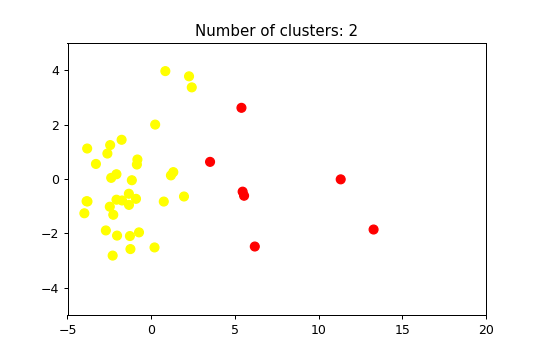

Counter({0: 37, 1: 7})

In [389]:
%matplotlib notebook
labels_kmeans, kmeans = run_KMEANS(X, 2)
collections.Counter(labels_kmeans)

### K-Medoids

Silhouette Coefficient: 0.337


<IPython.core.display.Javascript object>


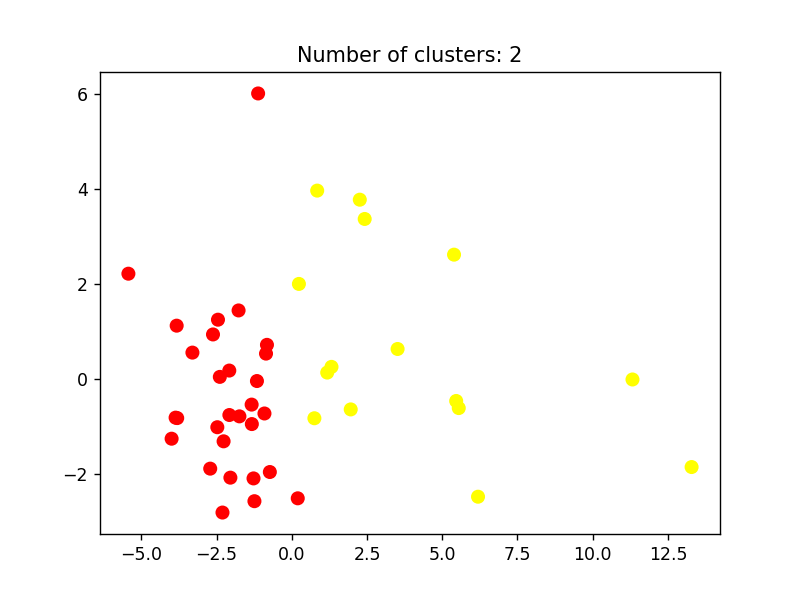

Counter({0: 15, 1: 29})

In [36]:
%matplotlib notebook
%matplotlib notebook 
labels_kmedoids, kmedoids = run_KMEDOIDS(X)
collections.Counter(labels_kmedoids)

Silhouette Coefficient: 0.305


<IPython.core.display.Javascript object>


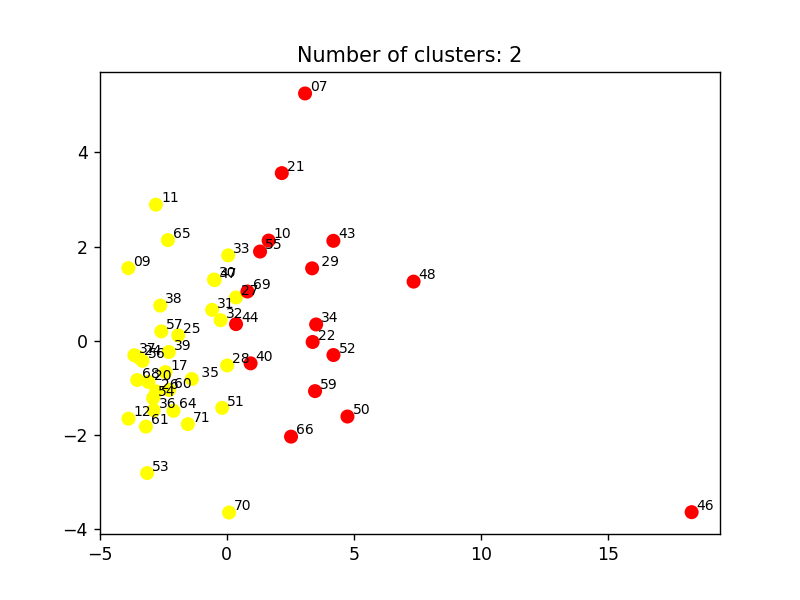

Counter({0: 32, 1: 17})

In [160]:
%matplotlib notebook
%matplotlib notebook 
labels_kmedoids, kmedoids = run_KMEDOIDS(X, df_names)
collections.Counter(labels_kmedoids)

Silhouette Coefficient: 0.331


<IPython.core.display.Javascript object>


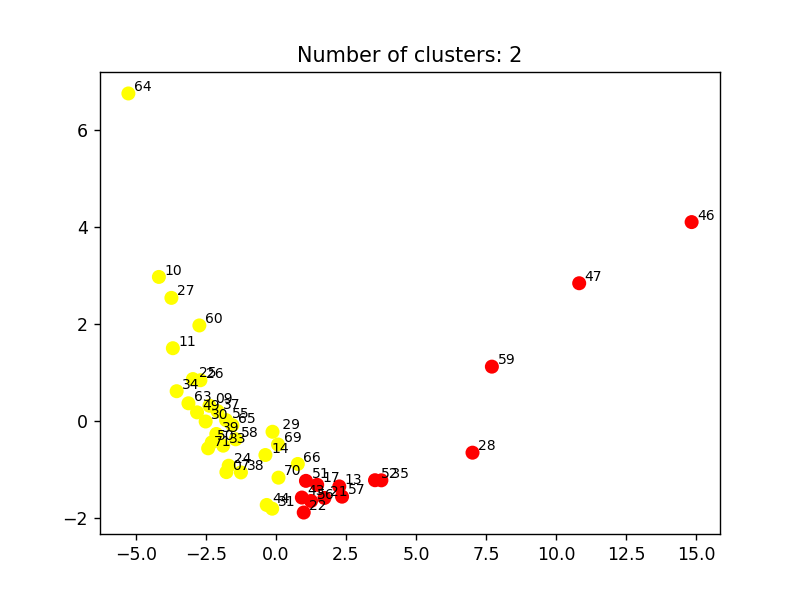

Counter({0: 30, 1: 14})

In [189]:
%matplotlib notebook
%matplotlib notebook 
labels_kmedoids, kmedoids = run_KMEDOIDS(X, df_names, [5,30])
collections.Counter(labels_kmedoids)

Silhouette Coefficient: 0.313


<IPython.core.display.Javascript object>


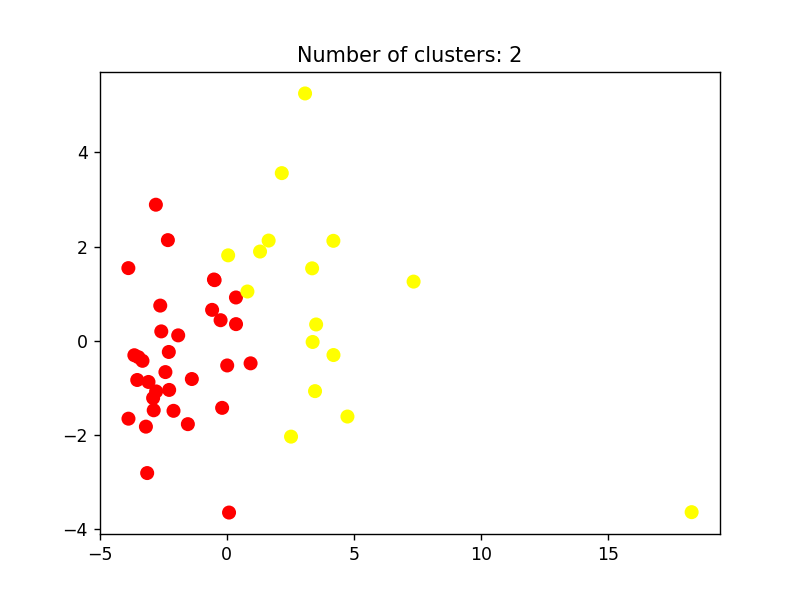

Counter({0: 16, 1: 33})

In [79]:
%matplotlib notebook
%matplotlib notebook 
labels_kmedoids, kmedoids = run_KMEDOIDS(X, [1,40])
collections.Counter(labels_kmedoids)

#### Feature importance

Feature ranking:
1. feature 3, DTW (0.139401)
2. feature 7, MeanLcs (0.116892)
3. feature 9, MinLcs (0.115117)
4. feature 12, NumberOfAoisHitsShort (0.101208)
5. feature 4, FixationsDuration (0.087048)
6. feature 13, NumberOfFixations (0.084631)
7. feature 10, MinLev (0.078363)
8. feature 8, MeanLev (0.046794)
9. feature 24, ReoccurrenceRate (0.032352)
10. feature 19, RecurrenceStandardDeviationY (0.028769)
11. feature 16, RecurrenceMeanY (0.027711)
12. feature 11, NumberOfAoisHits (0.024848)
13. feature 6, MaxLev (0.023600)
14. feature 5, MaxLcs (0.015692)
15. feature 14, Recurrence (0.013334)
16. feature 18, RecurrenceStandardDeviationX (0.012726)
17. feature 1, AverageSaccadeLength (0.010762)
18. feature 2, AverageSaccadeSpeed (0.009835)
19. feature 23, ReoccurrenceLaminarity (0.006352)
20. feature 15, RecurrenceMeanX (0.005776)
21. feature 22, ReoccurrenceDeterminism (0.005426)
22. feature 0, AverageFixationDuration (0.005410)
23. feature 20, Reoccurrence (0.004496)
24. feature 21,

<IPython.core.display.Javascript object>


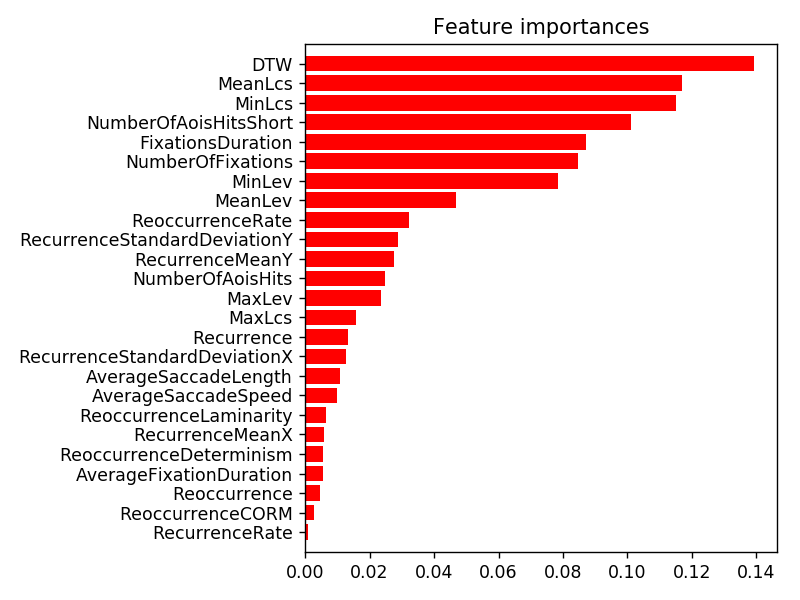

In [38]:
%matplotlib notebook
fu = featureImportance(X,labels_kmedoids,df_dropped_columns,300, 1)
#dlzka, trvanie a rychlost sakad ako crty pridat

Feature ranking:
1. feature 12, NumberOfAoisHitsShort (0.171616)
2. feature 9, MinLcs (0.124805)
3. feature 8, MeanLev (0.120586)
4. feature 7, MeanLcs (0.105119)
5. feature 14, Recurrence (0.076019)
6. feature 11, NumberOfAoisHits (0.069117)
7. feature 10, MinLev (0.067747)
8. feature 13, NumberOfFixations (0.055000)
9. feature 19, RecurrenceStandardDeviationY (0.044631)
10. feature 5, MaxLcs (0.041744)
11. feature 20, Reoccurrence (0.022578)
12. feature 18, RecurrenceStandardDeviationX (0.021110)
13. feature 16, RecurrenceMeanY (0.016743)
14. feature 4, FixationsDuration (0.016567)
15. feature 3, DTW (0.015684)
16. feature 6, MaxLev (0.009702)
17. feature 15, RecurrenceMeanX (0.008065)
18. feature 17, RecurrenceRate (0.003970)
19. feature 23, ReoccurrenceLaminarity (0.002755)
20. feature 21, ReoccurrenceCORM (0.002244)
21. feature 22, ReoccurrenceDeterminism (0.001469)
22. feature 0, AverageFixationDuration (0.001230)
23. feature 2, AverageSaccadeSpeed (0.000763)
24. feature 1, Avera

<IPython.core.display.Javascript object>


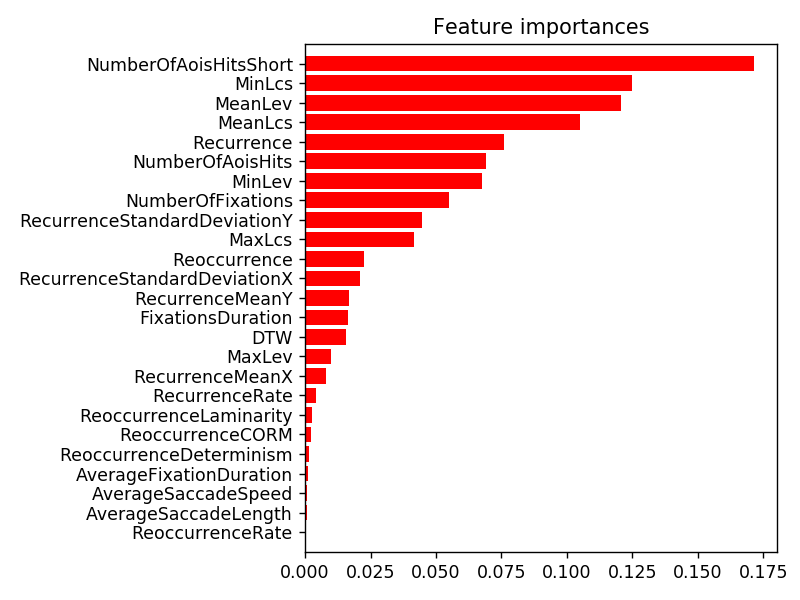

In [26]:
%matplotlib notebook
fu = featureImportance(X,labels_kmedoids,df_dropped_columns,300, 1)
#dlzka, trvanie a rychlost sakad ako crty pridat

Feature ranking:
1. feature 12, NumberOfAoisHitsShort (0.179391)
2. feature 8, MeanLev (0.125996)
3. feature 9, MinLcs (0.116875)
4. feature 7, MeanLcs (0.108660)
5. feature 11, NumberOfAoisHits (0.083754)
6. feature 14, Recurrence (0.083343)
7. feature 10, MinLev (0.064598)
8. feature 13, NumberOfFixations (0.046228)
9. feature 5, MaxLcs (0.038053)
10. feature 18, RecurrenceStandardDeviationX (0.031157)
11. feature 19, RecurrenceStandardDeviationY (0.026362)
12. feature 16, RecurrenceMeanY (0.018384)
13. feature 20, Reoccurrence (0.015965)
14. feature 15, RecurrenceMeanX (0.013759)
15. feature 17, RecurrenceRate (0.013249)
16. feature 3, DTW (0.009260)
17. feature 6, MaxLev (0.005764)
18. feature 4, FixationsDuration (0.004500)
19. feature 0, AverageFixationDuration (0.004030)
20. feature 23, ReoccurrenceLaminarity (0.003801)
21. feature 21, ReoccurrenceCORM (0.002506)
22. feature 22, ReoccurrenceDeterminism (0.002363)
23. feature 24, ReoccurrenceRate (0.000982)
24. feature 1, Average

<IPython.core.display.Javascript object>


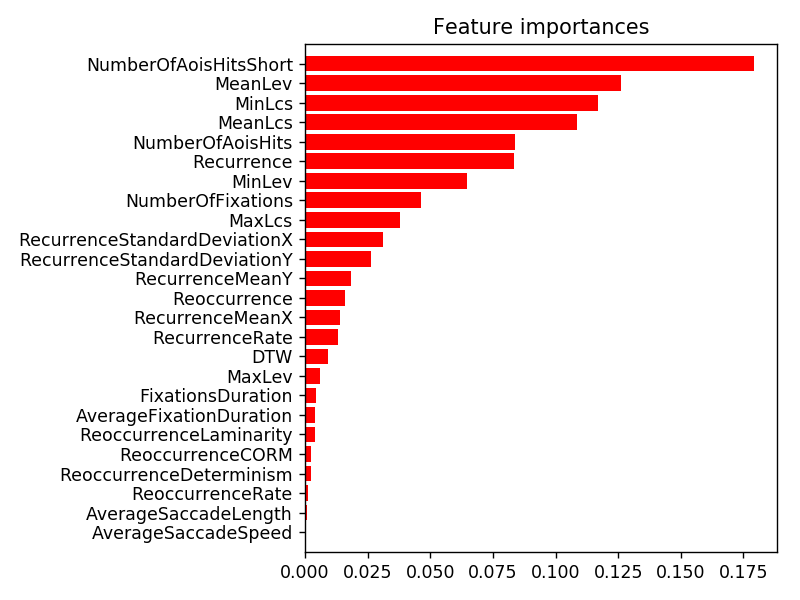

In [193]:
%matplotlib notebook
fu = featureImportance(X,labels_kmedoids,df_dropped_columns,300, 1)
#dlzka, trvanie a rychlost sakad ako crty pridat

Feature ranking:
1. feature 3, DTW (0.172627)
2. feature 7, MeanLcs (0.150029)
3. feature 9, MinLcs (0.106720)
4. feature 8, MeanLev (0.105009)
5. feature 12, NumberOfAoisHitsShort (0.097545)
6. feature 6, MaxLev (0.070237)
7. feature 11, NumberOfAoisHits (0.045516)
8. feature 10, MinLev (0.039798)
9. feature 16, RecurrenceMeanY (0.038732)
10. feature 4, FixationsDuration (0.035506)
11. feature 5, MaxLcs (0.023427)
12. feature 13, NumberOfFixations (0.022858)
13. feature 20, Reoccurrence (0.019847)
14. feature 15, RecurrenceMeanX (0.019826)
15. feature 14, Recurrence (0.015670)
16. feature 18, RecurrenceStandardDeviationX (0.011669)
17. feature 19, RecurrenceStandardDeviationY (0.006187)
18. feature 2, AverageSaccadeSpeed (0.006018)
19. feature 23, ReoccurrenceLaminarity (0.003777)
20. feature 1, AverageSaccadeLength (0.002977)
21. feature 21, ReoccurrenceCORM (0.002060)
22. feature 22, ReoccurrenceDeterminism (0.001700)
23. feature 0, AverageFixationDuration (0.001015)
24. feature 24,

<IPython.core.display.Javascript object>


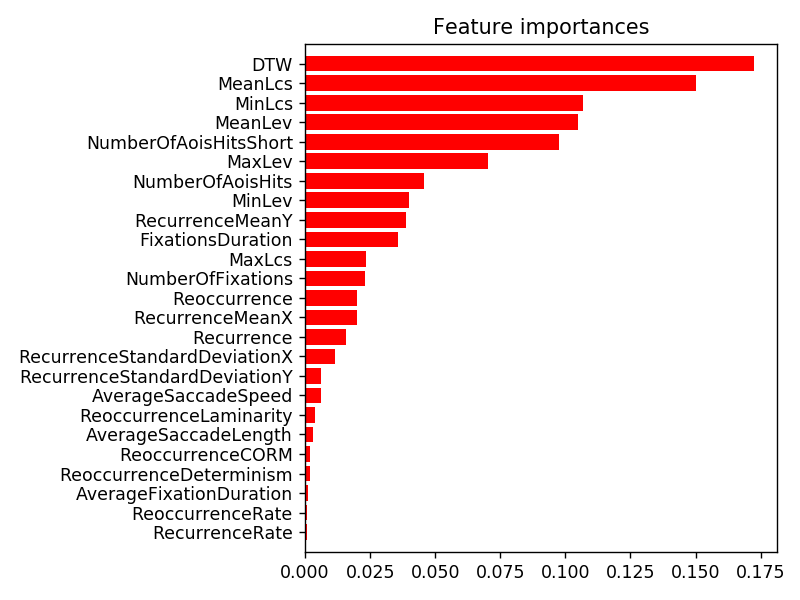

In [80]:
%matplotlib notebook
fu = featureImportance(X,labels_kmedoids,df_dropped_columns,300, 1)
#dlzka, trvanie a rychlost sakad ako crty pridat

In [99]:
df1.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,...,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,0.200791,206.418172,0.679627,41966.095536,22.357714,0.912662,72.183673,0.634162,20.051871,0.304276,...,47.611517,76.349703,0.266132,273.807715,438.602977,332.755102,-9.951830,4.314285,3.776205,4.290195
std,0.034944,49.087573,0.141845,16046.296996,15.899351,0.116837,8.159027,0.169125,9.713281,0.139364,...,28.305703,51.594945,0.096247,319.035094,565.746436,546.706180,12.173622,3.641111,2.993370,1.632917
min,0.132354,129.266936,0.372872,28294.013649,5.489000,0.428571,53.000000,0.212683,14.083333,0.065934,...,15.836364,25.131579,0.133634,38.882891,46.050443,21.000000,-34.640523,0.000000,0.398936,1.967556
25%,0.175154,171.435765,0.574936,31458.502055,11.742000,0.869565,66.000000,0.498162,15.687500,0.200000,...,28.195572,36.259709,0.200000,91.058782,119.892825,85.000000,-19.095581,2.030457,1.846966,3.102041
50%,0.194389,192.605348,0.659550,36471.666886,16.691000,0.937500,75.000000,0.640625,16.770833,0.285714,...,39.376623,63.250000,0.235123,169.188785,250.669050,147.000000,-10.354097,3.086420,2.941176,3.812620
75%,0.233292,228.296735,0.776392,47790.933681,30.560000,1.000000,79.000000,0.765625,20.854167,0.400000,...,55.754344,96.990832,0.305324,305.032533,536.753950,376.000000,-1.693548,5.074627,3.880597,5.192308
max,0.285070,344.815796,0.964555,123840.867029,97.203000,1.000000,85.000000,0.965278,71.916667,0.666667,...,162.225505,299.806226,0.569620,1914.025052,3520.650169,3577.000000,18.423813,13.821138,11.827957,9.125607


In [97]:
df2.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.199849,142.534510,0.535183,22473.405781,15.213750,0.927552,46.181818,0.634931,13.386892,0.308713,...,31.875611,53.463100,0.359775,161.148105,273.938735,343.068182,-7.594356,8.784128,6.876974,12.083862
std,0.045969,60.155186,0.180299,10196.610332,8.238824,0.122654,5.719297,0.193381,6.741332,0.147949,...,18.907561,33.482308,0.158446,167.739726,290.392460,321.010932,13.350190,8.281159,6.651138,6.215233
min,0.127066,74.234717,0.264302,14460.607230,3.302000,0.568966,32.000000,0.214916,9.372093,0.068966,...,7.142857,12.857143,0.051471,3.542330,4.335090,35.000000,-32.903019,0.315457,0.315457,2.512697
25%,0.168340,109.153784,0.405194,16329.898207,10.609250,0.927263,43.500000,0.473761,10.145349,0.197619,...,19.181597,31.759177,0.222935,43.107343,96.816642,120.750000,-15.565552,3.269231,2.543110,8.031283
50%,0.199780,119.528869,0.486380,17984.662239,12.789500,1.000000,48.000000,0.674101,10.802326,0.279221,...,26.976733,44.469319,0.363548,107.952017,198.436698,234.000000,-7.952125,7.120743,5.171409,10.196271
75%,0.219657,152.037288,0.590197,24279.454759,18.637000,1.000000,51.000000,0.810735,13.720930,0.432540,...,37.106232,65.231555,0.472016,184.866597,300.119188,428.250000,1.863727,11.541726,8.510467,17.585473
max,0.341219,320.517752,1.156722,56648.524161,42.169000,1.000000,54.000000,0.918605,45.604651,0.666667,...,99.685911,164.069215,0.633725,795.827122,1368.766121,1572.000000,28.238482,42.500000,35.000000,24.891147


In [96]:
df5.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.172070,261.318912,0.928393,67355.153434,21.332114,0.921615,55.727273,0.606620,20.736786,0.241232,...,47.514332,75.029971,0.258443,322.586544,509.384288,284.340909,9.909559,7.836719,7.804278,2.212096
std,0.027596,91.327897,0.283384,40132.721959,21.763042,0.115298,6.233308,0.195259,10.030569,0.130053,...,45.366453,76.329882,0.098309,543.590628,853.723618,577.309757,21.308039,11.472632,10.955451,0.870906
min,0.099087,126.031691,0.505883,41744.934132,2.617000,0.594203,42.000000,0.233906,14.581395,0.057971,...,3.666667,5.666667,0.054545,1.934099,2.617604,4.000000,-23.237377,0.000000,0.155280,0.600601
25%,0.153635,200.994218,0.758354,44720.220683,7.196250,0.881765,50.750000,0.466985,15.633721,0.146825,...,18.131980,25.277397,0.197639,38.878533,50.296194,18.750000,-7.753430,2.245551,2.224105,1.648185
50%,0.168405,239.048401,0.903417,53084.787496,14.429000,1.000000,56.000000,0.611309,16.953488,0.205263,...,34.596461,51.390671,0.245122,148.130305,205.517432,93.500000,5.272000,4.305556,5.248244,2.078571
75%,0.196484,295.048114,1.103963,66485.390756,25.725250,1.000000,60.250000,0.791990,20.191860,0.333333,...,60.941208,103.344923,0.308946,402.747424,531.345597,235.500000,23.799677,8.004386,8.092949,2.741182
max,0.229442,524.002790,1.829095,245737.317008,112.710000,1.000000,65.000000,0.959302,54.232558,0.571429,...,228.662841,360.283007,0.617665,2851.906305,4189.389140,3260.000000,62.500000,66.666667,66.666667,5.714286


In [95]:
df7.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,...,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.198081,179.654892,0.641818,59647.841523,17.878191,0.940602,43.617021,0.591087,13.098982,0.224050,...,39.538351,60.656886,0.360887,223.464702,357.375517,239.191489,-10.858141,2.981988,3.443175,5.822176
std,0.047312,40.239643,0.193800,35077.983479,14.147453,0.094129,5.084303,0.192544,6.698146,0.141654,...,25.842250,48.594675,0.115248,273.604900,507.103270,314.565445,18.857727,4.680515,4.870647,3.632521
min,0.123775,115.836069,0.294749,34879.873733,3.903000,0.603774,32.000000,0.198113,8.717391,0.037736,...,11.625000,14.000000,0.133333,8.859196,12.119200,2.000000,-46.648551,0.000000,0.200803,1.052632
25%,0.171088,156.156422,0.522012,40870.113167,8.661000,0.902381,40.500000,0.458862,9.728261,0.114379,...,21.614068,31.080135,0.277485,72.802782,105.583406,65.000000,-23.182831,0.413418,0.937957,3.487536
50%,0.189000,174.574760,0.625476,45008.209883,13.916000,1.000000,44.000000,0.608696,10.608696,0.200000,...,31.203666,44.050916,0.334192,116.291062,165.878789,148.000000,-9.914530,1.546392,1.804124,5.293932
75%,0.218531,206.078550,0.746853,63628.670404,23.790500,1.000000,47.000000,0.700483,12.641304,0.267857,...,49.736673,75.112902,0.413502,279.153237,395.822249,270.000000,-3.087316,2.967033,3.426473,7.013374
max,0.331117,328.365543,1.430175,199650.223549,70.686000,1.000000,51.000000,0.978261,42.804348,0.500000,...,124.494501,232.039385,0.674510,1385.501126,2554.219778,1847.000000,55.263158,21.739130,25.000000,20.027341


#### Get data from each cluster 

In [190]:
cluster_0, cluster_1 = split_data_to_2_clusters(labels_kmedoids, df_names, df_all_data)

X_cluster_0, df_names_cluster_0, df_all_data_cluster_0, df_dropped_cluster_0 = prepare_data(cluster_0["Name"], COLUMNS_TO_DROP_0)
X_cluster_1, df_names_cluster_1, df_all_data_cluster_1, df_dropped_cluster_1 = prepare_data(cluster_1["Name"], COLUMNS_TO_DROP_0)

In [203]:
df5_cluster_0 = df_all_data_cluster_0
df5_cluster_1 = df_all_data_cluster_1

In [199]:
df_all_data_cluster_0.describe().iloc[:,3:15]

,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,MinLev,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,Recurrence
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,49820.295659,11.718000,0.980898,57.766667,0.708366,16.282946,0.301945,4.766667,50.233333,12.833333,65.800000,687.800000
std,8800.831175,8.291308,0.037921,4.023066,0.137334,1.263912,0.111552,3.013571,29.220545,5.583741,40.703639,987.297335
min,41744.934132,2.617000,0.880000,50.000000,0.483476,14.581395,0.120000,1.000000,12.000000,4.000000,15.000000,3.000000
25%,43446.464083,6.148000,1.000000,55.000000,0.604560,15.430233,0.202632,3.000000,33.500000,8.250000,37.000000,102.500000
50%,46231.948774,8.434500,1.000000,58.000000,0.712549,15.883721,0.292857,4.000000,42.000000,12.000000,51.000000,241.000000
75%,53638.215757,14.725500,1.000000,60.750000,0.806063,17.069767,0.375000,6.750000,56.750000,17.000000,89.750000,915.750000
max,78915.929528,33.671000,1.000000,65.000000,0.959302,19.209302,0.571429,12.000000,134.000000,25.000000,169.000000,3956.000000


In [200]:
df_all_data_cluster_1.describe().iloc[:,3:15]

,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,MinLev,NumberOfAoisHits,NumberOfAoisHitsShort,NumberOfFixations,Recurrence
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,104929.848664,41.933786,0.794580,51.357143,0.388591,30.280731,0.111134,19.857143,202.928571,40.571429,247.785714,13130.928571
std,54080.418409,27.255941,0.123588,7.889693,0.094616,13.614714,0.038114,9.796837,111.236038,17.310354,138.025738,15805.827696
min,56700.691385,20.295000,0.594203,42.000000,0.233906,18.930233,0.057971,11.000000,108.000000,26.000000,127.000000,2412.000000
25%,63607.807656,23.138750,0.767081,47.000000,0.336131,20.319767,0.082964,12.250000,128.250000,27.250000,143.000000,3186.000000
50%,89460.680670,31.468500,0.807407,49.500000,0.437569,21.569767,0.120238,14.000000,174.000000,29.000000,209.000000,6355.000000
75%,133764.144671,50.095000,0.883929,51.000000,0.464686,34.325581,0.146825,23.750000,247.000000,48.250000,295.750000,16587.250000
max,245737.317008,112.710000,0.962963,65.000000,0.503578,54.232558,0.153846,40.000000,519.000000,69.000000,570.000000,56193.000000


In [233]:
dd = df_all_data_cluster_1[df_all_data_cluster_1["Name"] != "Tester46"]
dd = dd[dd["Name"] != "tester59"]
dd = dd[dd["Name"] != "tester47"]
dd = dd[dd["Name"] != "tester28"]

In [236]:
dd['Scanpath'].apply(len).mean()

148.0

In [234]:
dd2 = df_all_data_cluster_0[df_all_data_cluster_0["Name"] != "tester64"]
dd2 = dd2[dd2["Name"] != "tester60"]
dd2 = dd2[dd2["Name"] != "tester11"]
dd2 = dd2[dd2["Name"] != "tester27"]
dd2 = dd2[dd2["Name"] != "tester10"]

In [235]:
dd2['Scanpath'].apply(len).mean()

55.76

In [230]:
df_all_data_cluster_1['ScanpathShort']

0                           FGFEFEFEGFDHIHGFGFEFCDEFGHI
1     DFDEFEDFGHGDGDHIHGDFEFDEFECEFDGDFDECDGHDHGDHGHIHI
2                          DFEFDECFEDEDEDEDCFDECFGDHDHI
3     DBDEFDGDGDHIHGHDGHDHGHIHGHDFDEDEDCEFEGDGHIHGDG...
4                        FDACEFDEHGDGHIHDACDECAFGDGDGHI
5         EFEFDEDFEFDGDHIHIDFDGFEFDEGDGHGDGHGHGDGDFDGHI
6                          DEFEDFDEDEDEFDAEFEFDGHGDGDHI
7                          DEDEFEDHGDGDGHDGDFEDGDHIDGHG
8                            DEFDEFGHGDGDFDFEDGHGHIHIHI
9                           EFDEGDGDHIHIGHIHGDEFGHGHGHI
10    FEFEFDFDCEFEFEBADGDGHGIHIHIHGDFDFDEFEFEFEBEDGD...
11                          EFEFDFEGFEFGHDEFEFDEFGHGHGI
12       DFEFDGHIHGDHGDFEDFDGDGDGEDHGIHGHGHGDHGHGHDFEHI
13    FEDGDGHDGDGHGDFDFEFEDEDEDHGHGDGDGDGHDGHGHIHFED...
Name: ScanpathShort, dtype: object

In [229]:
df_all_data_cluster_0['ScanpathShort']

0                       DEDGHGI
1                       FEGHIHI
2                     EDEGDHIHI
3             DEDFCDGDHGDFEFECD
4                          DGHI
5                       DEFDGHI
6                DFEDEFEDGHGDHI
7                      DGFEDGHI
8             EDFEFDGDHIHIHGIDF
9           DEDHGHIHGHIHIHGEGEI
10                  DEDEDEFDGHI
11              DFEFEFDEFEFGDGI
12                   DFEDGHGDGI
13                     DFEDFDGI
14             DEFDEFHGDFEFEGHI
15    DEDEDFEDFCECEFEFEDGDGHIHI
16                     DEDFEGHI
17     DFDEDGDHIHGDFDEFEFDFEDGI
18                    DEDGDGHID
19         DFEDEFDHGHIHIHGHDFED
20                EFEFDGHGFHIHI
21            FEGDGCAEDEFGHIDEG
22                  EFDEFGFHIHI
23         DFEFEDGHGDGHGDHGHGHI
24            DEFEDEDHGDGDFDFHI
25                         EHGI
26                    DEDEDHIHI
27                   DEDEDGHIHI
28             EFEDEFDEFDEDGDHI
29                DEDEDHGDGDGHI
Name: ScanpathShort, dtype: object

### Prepare data from one cluster to LOF

## LOF - Local outlier factor

http://scikit-learn.org/dev/auto_examples/plot_anomaly_comparison.html
http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.correlation.html#scipy.spatial.distance.correlation
https://docs.scipy.org/doc/scipy/reference/spatial.distance.html

<IPython.core.display.Javascript object>


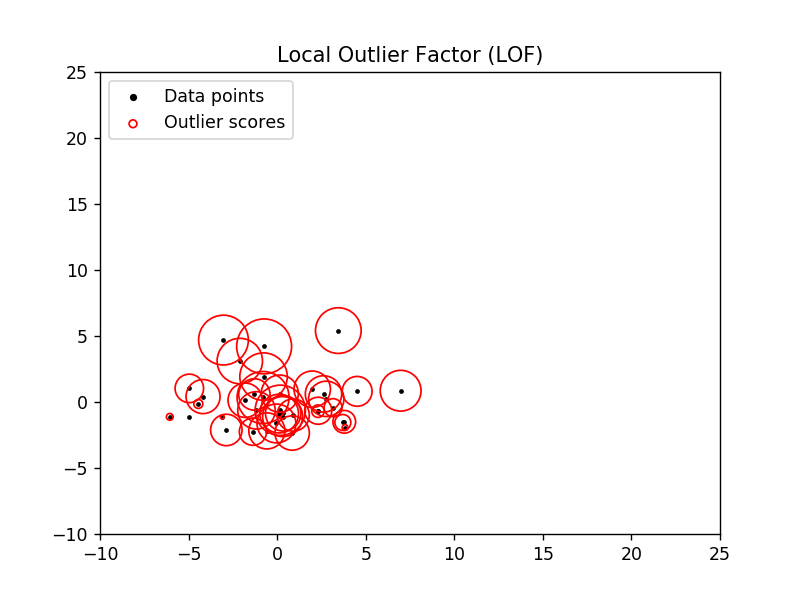

In [77]:
X_scores_cluster_0 = run_LOF(X_cluster_0, 25, "correlation", True)

Poparujem participantov a ich skore

In [79]:
paired_scores_orig = pair_scores_with_participants(X_scores, np.array(df_names_lof))
paired_scores = pair_scores_with_participants(X_scores, np.array(df_names_lof))
paired_scores_sorted = sorted(paired_scores, key=lambda x: x[1])
pddf = pd.DataFrame(paired_scores_sorted)
pddf

,0,1
0,tester10,-1.026
1,tester31,-1.021
2,tester61,-1.019
3,tester11,-1.018
4,tester39,-1.015
5,tester40,-1.013
6,tester32,-1.012
7,tester36,-1.007
8,tester13,-1.006
9,tester64,-1.005


In [135]:
d1 = []
d2 = []
t1 = "tester27"
t2 = "tester36"
for d in ALL_PARTICIPANTS[t1].data:
    if((d != "Scanpath") & (d != "ScanpathShort") & (d != "Name")):
        d1.append(ALL_PARTICIPANTS[t1].data[d])
    
for d in ALL_PARTICIPANTS[t2].data:
    if((d != "Scanpath") & (d != "ScanpathShort") & (d != "Name")):
        d2.append(ALL_PARTICIPANTS[t2].data[d])
    
correlation(d1,d2)

0.8543531914160853

### Find Outliers Using Normal Distribution and S.D

Kedze neviem urcit treshold pre outlier skore, ktore bolo vystupom z algoitmu LOF tak tym neviem oznacit, kto uz na zaklade skore je a kto nie je outlier. Preto pouzijem normalnu distribuciu spolu so standardnou odchylkou a na zaklade hodnot skorej najde v datach take skore, ktore mozme povazovat za anomalne. (Skusal som aj z-skore)

In [67]:
outliers = outliers_nd_sd(X_scores, paired_scores_orig)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Outliers in data -> ['tester31']


### Compare data without outliers  to outliers data

#### Data with outliers

In [32]:
df_cluster_1_without_outliers = df_cluster_1.loc[~df_cluster_1['Name'].isin(outliers)]
df_cluster_1_without_outliers.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,...,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,0.201084,128.023219,0.484486,18870.450352,12.093486,0.980049,47.400000,0.712105,11.239610,0.354836,...,25.242519,41.110150,0.345337,100.311174,166.019335,265.000000,-5.974912,10.372565,8.132455,13.820842
std,0.049899,48.654690,0.134975,3045.784323,4.705717,0.045544,4.716679,0.139321,1.488494,0.129154,...,9.552281,16.210982,0.165822,65.067492,108.604219,201.015071,12.654571,8.516121,6.860013,5.690314
min,0.127066,74.234717,0.264302,15157.468209,3.302000,0.800000,33.000000,0.399091,9.704545,0.120000,...,7.142857,12.857143,0.051471,3.542330,4.335090,35.000000,-32.776471,0.588235,1.176471,3.961353
25%,0.164420,104.103416,0.393291,16478.881614,9.302500,1.000000,44.500000,0.602273,10.284091,0.250000,...,18.610967,27.787556,0.211272,41.165842,62.943151,117.000000,-13.470292,5.653987,4.256293,9.630791
50%,0.200577,117.135089,0.468630,17997.851155,11.175000,1.000000,48.000000,0.715909,10.954545,0.300000,...,25.118483,40.240099,0.381847,90.915910,146.953540,230.000000,-7.497911,8.089669,6.209150,12.994350
75%,0.222173,135.198949,0.536197,20553.984894,14.335000,1.000000,51.000000,0.835227,11.363636,0.472222,...,30.244636,50.607627,0.453602,142.183165,233.679207,356.500000,3.073145,12.383708,10.931515,18.036859
max,0.341219,304.826608,0.884331,26897.230418,25.041000,1.000000,54.000000,0.920455,17.113636,0.666667,...,46.424571,73.730352,0.633725,267.600121,431.506941,1026.000000,28.238482,42.500000,35.000000,24.891147


## 2. pristup
### LOF - nad celym datasetom
#### 2.1 Metric - correlation

<IPython.core.display.Javascript object>


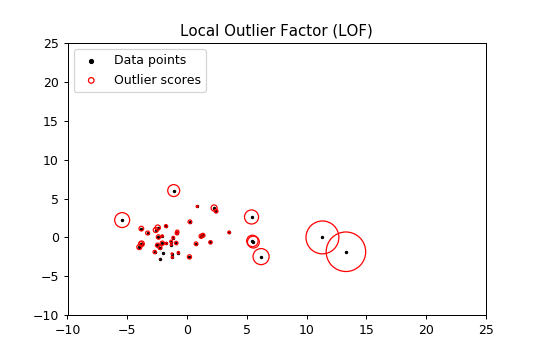

(array([-1.00274103, -1.07159256, -0.99504802, -0.99889484, -0.99730621,
        -1.00283861, -0.99843092, -1.12078156, -0.98802291, -0.99228926,
        -0.99786311, -1.14192291, -0.99816337, -0.99029161, -1.63198975,
        -0.99005051, -1.10608265, -0.99120082, -0.99244692, -0.99484849,
        -0.99456645, -1.00984386, -1.06595115, -0.99062733, -1.00612798,
        -0.99809793, -0.98984316, -0.99449429, -0.99098465, -0.98932275,
        -0.99924143, -0.98795846, -0.9975538 , -0.99227067, -1.00428679,
        -0.99618128, -1.07280159, -1.91915955, -0.99633081, -0.99440094,
        -0.99574336, -1.00074088, -0.99369565, -0.99704234]),
 LocalOutlierFactor(algorithm='auto', contamination=0.05, leaf_size=30,
           metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=35,
           p=2))

In [429]:
%matplotlib notebook
run_LOF(X, 35, "minkowski", True)

<IPython.core.display.Javascript object>


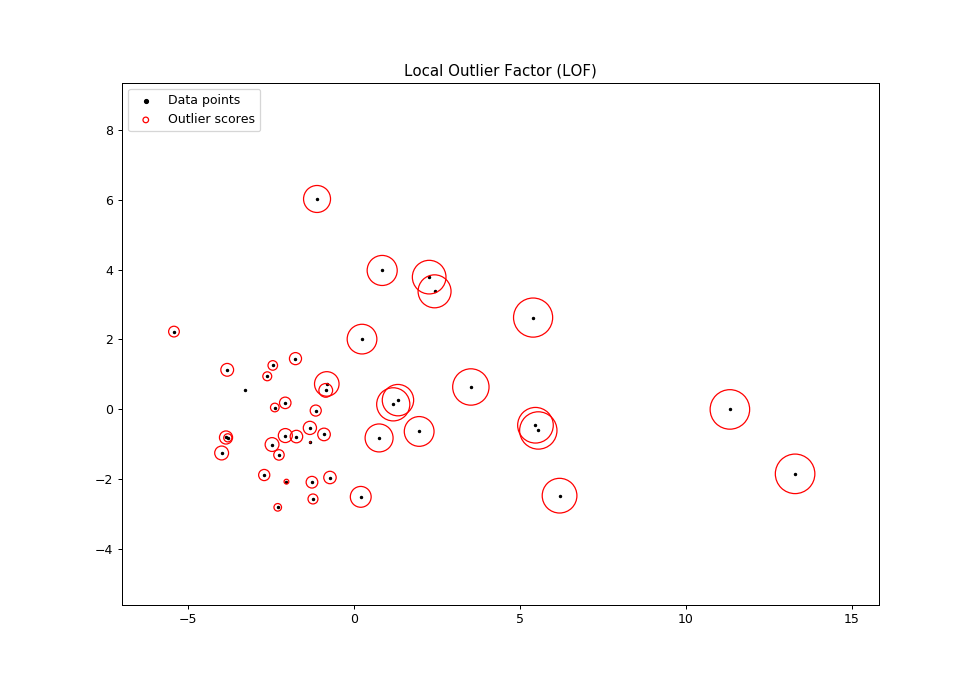

array([-0.99302426, -1.11234078, -0.98963057, -0.99339432, -0.98475872,
       -0.98182176, -1.01702241, -0.98532506, -0.9796367 , -1.10518452,
       -1.07168122, -1.09348398, -0.99292118, -0.98377248, -1.12892122,
       -1.0636345 , -1.12585022, -0.98927143, -0.9912473 , -1.06183813,
       -1.03368245, -1.08618045, -1.09988451, -0.98705646, -0.98050157,
       -1.08309659, -0.9739876 , -0.98631245, -0.98947872, -0.98746532,
       -0.98133323, -0.97620584, -0.99099097, -0.98608237, -0.98300283,
       -1.0614447 , -1.04617655, -1.12904854, -1.08189553, -0.99261716,
       -1.05161799, -0.99015217, -0.98845049, -0.97394157])

In [195]:
%matplotlib notebook
%matplotlib notebook
run_LOF(X, 25, "correlation", True)

In [168]:
X_cluster_0

array([[-6.03781748e-01, -1.23126009e+00, -1.12787386e+00,
        -4.58003813e-01,  7.43941828e-03,  6.33080407e-01,
         3.41839771e-01,  3.04962092e-01, -8.35932197e-01,
         2.02091966e-01, -4.85418841e-01,  3.84609769e-01,
        -2.00296956e-01,  2.89818044e-01,  2.66964860e-02,
         4.58501556e-01,  7.39156136e-02,  1.45219446e-01,
         3.82356394e-01,  1.10320648e-01,  8.91379638e-02,
         7.53200817e-01,  1.69280012e+00,  1.46442147e+00,
        -7.67103016e-02],
       [ 6.15750038e-01,  1.12316708e-01, -1.14333580e+00,
        -6.40548865e-01, -7.63628051e-01,  6.33080407e-01,
         5.79641351e-01,  2.92897041e-01, -1.63908274e-02,
         7.55255001e-01, -4.85418841e-01, -9.87010611e-01,
        -5.56380434e-01, -1.01989403e+00, -7.16495375e-01,
        -8.07197825e-01, -9.37155579e-01, -1.79696002e-01,
        -7.59473754e-01, -7.86161881e-01, -4.77044881e-01,
        -3.04699188e-02, -4.60701069e-01, -4.26930409e-01,
         1.62433422e+00],
    

In [169]:
all_X_scores = []
X_ = X_cluster_0
df_names_lof = df_names_cluster_0
for k in loopRange(11,14):
    sc, lf = run_LOF(X_ ,df_names_lof, k, "correlation")
    all_X_scores.append(sc)

pso = pair_multiple_scores_with_participants(all_X_scores, np.array(df_names_lof))
fr = pd.DataFrame(pso)
pso_max = []
scoores = []
for name in pso:
    pso_max.append([name[0],np.min(name[1])])
    scoores.append(np.min(name[1]))
    
#pso_max
pso_max_sorted = sorted(pso_max, key=lambda x: x[1])
pddf1 = pd.DataFrame(pso_max_sorted)
pddf1

,0,1
0,tester25,-1.120
1,tester65,-1.103
2,tester39,-1.103
3,tester38,-1.095
4,tester64,-1.092
5,tester 35,-1.087
6,tester32,-1.085
7,tester30,-1.073
8,tester11,-1.071
9,tester47,-1.062


<IPython.core.display.Javascript object>


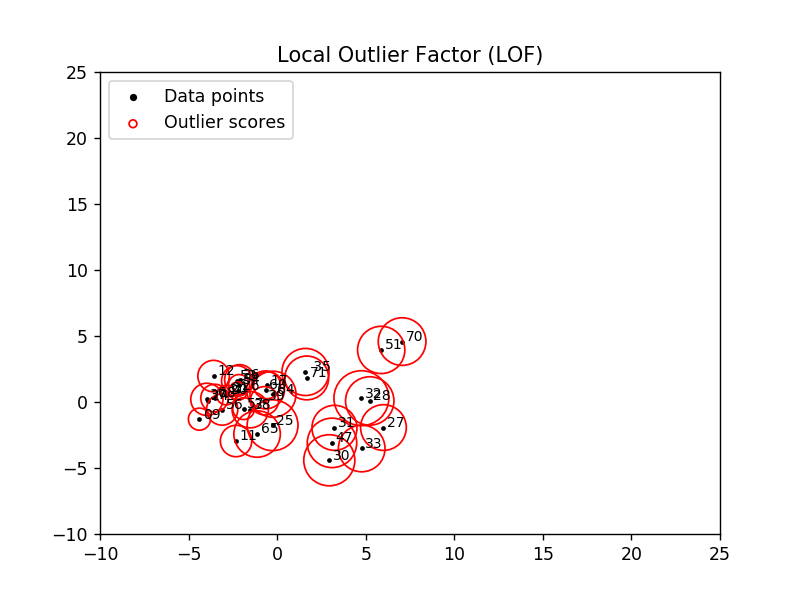

In [182]:
sc, lf = run_LOF(X_ ,df_names_lof, k, "correlation", True)

In [427]:
#outliers = outliers_z_score(X_scores)
outliers = outliers_nd_sd(np.array(scoores), pso_max)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Outliers in data -> []


<IPython.core.display.Javascript object>


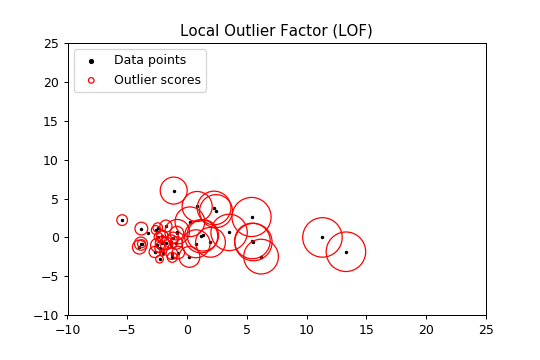

In [424]:
s, llf = run_LOF(X, 25, "correlation", True)

In [430]:
radius = (s.max() - s) / (s.max() - s.min())

In [445]:
radius

array([1.23029232e-01, 8.92282315e-01, 1.01149566e-01, 1.25415049e-01,
       6.97399792e-02, 5.08048707e-02, 2.77749214e-01, 7.33912084e-02,
       3.67174589e-02, 8.46144741e-01, 6.30143477e-01, 7.70709461e-01,
       1.22364690e-01, 6.33815234e-02, 9.99179134e-01, 5.78264992e-01,
       9.79379872e-01, 9.88341078e-02, 1.11572861e-01, 5.66683473e-01,
       3.85159203e-01, 7.23622426e-01, 8.11974709e-01, 8.45538793e-02,
       4.22934235e-02, 7.03740235e-01, 2.96781211e-04, 7.97570906e-02,
       1.00170583e-01, 8.71898249e-02, 4.76552634e-02, 1.45981611e-02,
       1.09920251e-01, 7.82737194e-02, 5.84194628e-02, 5.64147017e-01,
       4.65710760e-01, 1.00000000e+00, 6.95996852e-01, 1.20404592e-01,
       5.00792586e-01, 1.04512399e-01, 9.35413762e-02, 0.00000000e+00])

In [446]:
ALL_PARTICIPANTS["tester28"].data

{'AverageFixationDuration': 0.21903636363636364,
 'AverageSaccadeLength': 107.59831147614253,
 'AverageSaccadeSpeed': 0.4333531371558322,
 'DTW': 16319.049688132069,
 'FixationsDuration': 12.047,
 'MaxLcs': 1.0,
 'MaxLev': 52,
 'MeanLcs': 0.8604651162790699,
 'MeanLev': 10.813953488372093,
 'MinLcs': 0.6666666666666666,
 'MinLev': 2,
 'Name': 'tester28',
 'NumberOfAoisHits': 55,
 'NumberOfAoisHitsShort': 6,
 'NumberOfFixations': 55,
 'Recurrence': 808.0,
 'RecurrenceMeanX': 26.737623762376238,
 'RecurrenceMeanY': 40.24009900990099,
 'RecurrenceRate': 0.6337254901960784,
 'RecurrenceStandardDeviationX': 119.1918869316864,
 'RecurrenceStandardDeviationY': 182.0806470711799,
 'Reoccurrence': 306,
 'ReoccurrenceCORM': -19.970951343500364,
 'ReoccurrenceDeterminism': 2.6143790849673203,
 'ReoccurrenceLaminarity': 1.7973856209150327,
 'ReoccurrenceRate': 20.606060606060606,
 'Scanpath': 'DDEFDDDEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',
 'ScanpathShort': 'DEFDEF'}

In [205]:
#pso_max
pso_max_sorted = sorted(pso_max, key=lambda x: x[1])
pddf1 = pd.DataFrame(pso_max_sorted)
pddf1

,0,1
0,tester12,-1.091
1,tester08,-1.086
2,tester59,-1.078
3,tester33,-1.067
4,tester26,-1.065
5,tester 35,-1.057
6,tester22,-1.054
7,tester32,-1.048
8,tester11,-1.042
9,tester34,-1.042


In [223]:
#outliers = outliers_z_score(X_scores)
outliers = outliers_nd_sd(np.array(scoores), pso_max)
outliers = [x[0] for x in outliers]
print("Outliers in data -> " + str(outliers))

Outliers in data -> ['tester49']


In [77]:
tz = pddf.drop([0], axis=1)
z = np.abs(stats.zscore(np.array(tz)))
#print(z)

In [208]:
ok = outliers_nd_sd(z, paired_scores_orig)
ok = [x for x in outliers]
print("Outliers in data -> " + str(ok))

NameError: name 'z' is not defined

In [93]:
pss = sorted(paired_scores, key=lambda x: x[1], reverse=True)
pddf2 = pd.DataFrame(pss)
#outliers = outliers_z_score(X_scores)
out = outliers_nd_sd(X_scores, np.array(hhd))
out = [x[0] for x in out]
print("Outliers in data -> " + str(out))

Outliers in data -> []


#### Pair participants with their score

### Compare

In [41]:
df_outliers = df_all_data.loc[df_all_data['Name'].isin(outliers)]
if(len(df_outliers) > 1):
    s = df_outliers.describe()
else:
    s = df_outliers
    
s

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.149326,187.335573,0.599206,37926.148745,20.50400,0.782116,48.250000,0.464570,26.028409,0.216612,...,50.947910,91.526319,0.289608,381.019637,672.791105,655.000000,4.783374,20.919518,16.518619,8.055691
std,0.016742,86.300224,0.189709,21056.784986,18.95386,0.183207,5.678908,0.300986,16.415578,0.199128,...,48.201229,82.858331,0.172205,416.969509,719.641133,751.321946,19.001474,20.501225,16.466017,7.341662
min,0.129870,114.680741,0.389799,15157.468209,3.30200,0.568966,42.000000,0.220219,11.068182,0.068966,...,7.142857,12.857143,0.051471,3.542330,4.335090,40.000000,-16.548435,0.826972,0.604326,3.961353
25%,0.139110,127.173610,0.464052,22474.890472,5.30600,0.680285,44.250000,0.259230,13.096591,0.082459,...,10.776245,23.492695,0.239205,31.751087,77.083086,40.750000,-5.960773,4.860311,3.796376,4.142914
50%,0.149714,164.917471,0.614032,39828.655146,18.27250,0.779748,48.500000,0.377743,23.875000,0.148741,...,48.481436,94.589460,0.323516,362.354547,659.031604,504.000000,3.721724,20.175549,15.235075,4.606896
75%,0.159930,225.079434,0.749186,55279.913418,33.47050,0.881579,52.500000,0.583084,36.806818,0.282895,...,88.653101,162.623085,0.373919,711.623097,1254.739623,1118.250000,14.465871,36.234756,27.957317,8.519674
max,0.168004,304.826608,0.778963,56889.816479,42.16900,1.000000,54.000000,0.882576,45.295455,0.500000,...,99.685911,164.069215,0.459930,795.827122,1368.766121,1572.000000,28.238482,42.500000,35.000000,19.047619


In [42]:
df_without_outliers = df_all_data.loc[~df_all_data['Name'].isin(outliers)]
df_without_outliers.describe()

,AverageFixationDuration,AverageSaccadeLength,AverageSaccadeSpeed,DTW,FixationsDuration,MaxLcs,MaxLev,MeanLcs,MeanLev,MinLcs,...,RecurrenceMeanX,RecurrenceMeanY,RecurrenceRate,RecurrenceStandardDeviationX,RecurrenceStandardDeviationY,Reoccurrence,ReoccurrenceCORM,ReoccurrenceDeterminism,ReoccurrenceLaminarity,ReoccurrenceRate
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,0.205319,140.004355,0.536111,22144.104198,15.068561,0.938487,45.634146,0.650655,12.623614,0.313038,...,30.630462,50.723025,0.364590,144.022517,240.997102,311.439024,-8.960690,7.410829,5.789334,12.259098
std,0.044463,57.153959,0.184388,8171.392344,6.999101,0.108914,6.085869,0.178192,3.486633,0.143534,...,13.711885,24.030715,0.156273,113.394609,190.495979,240.301690,12.179499,5.200521,4.197628,6.149996
min,0.127066,74.234717,0.264302,15424.789111,4.755000,0.600000,32.000000,0.311869,9.704545,0.111111,...,10.350877,13.754386,0.122449,17.510435,23.442677,35.000000,-32.903019,0.315457,0.315457,2.512697
25%,0.176971,107.598311,0.406261,16970.239974,10.701000,0.937500,42.000000,0.512987,10.386364,0.200000,...,22.173104,37.274882,0.223251,84.571488,132.868438,133.000000,-15.445791,3.076923,2.519380,8.490566
50%,0.208179,118.168692,0.483956,18404.995142,13.532000,1.000000,48.000000,0.688017,11.045455,0.285714,...,27.215842,44.816121,0.381847,108.498782,214.792749,238.000000,-9.507602,6.722689,5.039788,10.402533
75%,0.222058,151.658040,0.589657,24456.348013,18.228000,1.000000,51.000000,0.814935,13.250000,0.428571,...,37.052212,64.800320,0.491300,184.129648,298.869679,377.000000,-4.725146,10.869565,8.185841,17.553191
max,0.341219,320.517752,1.156722,48797.870856,32.263000,1.000000,54.000000,0.920455,23.022727,0.666667,...,68.720441,111.147708,0.633725,538.424025,856.832347,1046.000000,17.663606,24.427481,18.511450,24.891147


<IPython.core.display.Javascript object>


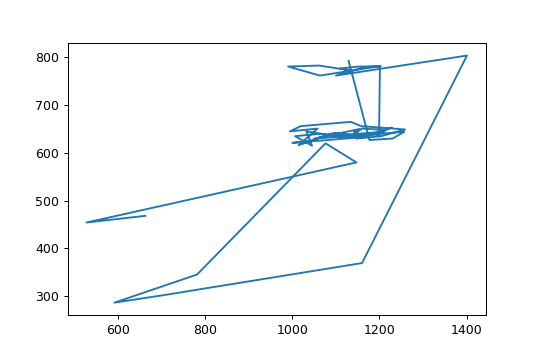

In [487]:
#plt.plot(par_data_point["tester61"][:,0], par_data_point["tester61"][:,1])
#plt.plot(par_data_point["tester63"][:,0], par_data_point["tester63"][:,1])
plt.plot(ALL_PARTICIPANTS["tester28"].fixationsToAoi[:,0], ALL_PARTICIPANTS["tester28"].fixationsToAoi[:,1])
#plt.plot(ALL_PARTICIPANTS["tester51"].fixationsToAoi[:,0], ALL_PARTICIPANTS["tester51"].fixationsToAoi[:,1])
#plt.plot(par_data_point["tester63"])
plt.show()


In [488]:
ALL_PARTICIPANTS["tester28"].data

{'AverageFixationDuration': 0.21903636363636364,
 'AverageSaccadeLength': 107.59831147614253,
 'AverageSaccadeSpeed': 0.4333531371558322,
 'DTW': 16319.049688132069,
 'FixationsDuration': 12.047,
 'MaxLcs': 1.0,
 'MaxLev': 52,
 'MeanLcs': 0.8604651162790699,
 'MeanLev': 10.813953488372093,
 'MinLcs': 0.6666666666666666,
 'MinLev': 2,
 'Name': 'tester28',
 'NumberOfAoisHits': 55,
 'NumberOfAoisHitsShort': 6,
 'NumberOfFixations': 55,
 'Recurrence': 808.0,
 'RecurrenceMeanX': 26.737623762376238,
 'RecurrenceMeanY': 40.24009900990099,
 'RecurrenceRate': 0.6337254901960784,
 'RecurrenceStandardDeviationX': 119.1918869316864,
 'RecurrenceStandardDeviationY': 182.0806470711799,
 'Reoccurrence': 306,
 'ReoccurrenceCORM': -19.970951343500364,
 'ReoccurrenceDeterminism': 2.6143790849673203,
 'ReoccurrenceLaminarity': 1.7973856209150327,
 'ReoccurrenceRate': 20.606060606060606,
 'Scanpath': 'DDEFDDDEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF',
 'ScanpathShort': 'DEFDEF'}

In [489]:
ALL_PARTICIPANTS["tester59"].data

{'AverageFixationDuration': 0.168003984063745,
 'AverageSaccadeLength': 131.33789923509678,
 'AverageSaccadeSpeed': 0.48880276479492407,
 'DTW': 54491.490595899835,
 'FixationsDuration': 42.169,
 'MaxLcs': 0.5689655172413793,
 'MaxLev': 54,
 'MeanLcs': 0.21491579791499602,
 'MeanLev': 45.604651162790695,
 'MinLcs': 0.06896551724137931,
 'MinLev': 25,
 'Name': 'tester59',
 'NumberOfAoisHits': 236,
 'NumberOfAoisHitsShort': 58,
 'NumberOfFixations': 251,
 'Recurrence': 10489.0,
 'RecurrenceMeanX': 84.97549814090952,
 'RecurrenceMeanY': 164.06921536848125,
 'RecurrenceRate': 0.34524867515881635,
 'RecurrenceStandardDeviationX': 683.5550889330078,
 'RecurrenceStandardDeviationY': 1368.766121440612,
 'Reoccurrence': 1572,
 'ReoccurrenceCORM': -2.4315521628498726,
 'ReoccurrenceDeterminism': 0.8269720101781171,
 'ReoccurrenceLaminarity': 0.6043256997455471,
 'ReoccurrenceRate': 5.010358565737052,
 'Scanpath': 'FFFFFFFEEFFFFFFFFFEEEEDDDDEEEDDDEEDDDEEEDDEDDEDDDEEDDDDEEEEEEDDDEDDDDDEEEDDEEDDEED

In [465]:
without = df_all_data[df_all_data["Name"] != "tester28"]

In [480]:
for ds in without.columns:
    if((ds != "Name")):
        print(ds + " " + str(without[ds].mean()))

AverageFixationDuration 0.1994024848478371
AverageSaccadeLength 143.34698021174881
AverageSaccadeSpeed 0.537550938911181
DTW 22616.530341269718
FixationsDuration 15.287395348837213
MaxLcs 0.9258674522950501
MaxLev 46.04651162790697
MeanLcs 0.6296861007849504
MeanLev 13.446727961060034
MinLcs 0.30038824431682765
MinLev 4.976744186046512
NumberOfAoisHits 72.67441860465117
NumberOfAoisHitsShort 15.744186046511627
NumberOfFixations 78.88372093023256
Recurrence 1445.8139534883721
RecurrenceMeanX 31.995098748863136
RecurrenceMeanY 53.77061178794639
RecurrenceRate 0.3534044738988555
RecurrenceStandardDeviationX 162.12383118900536
RecurrenceStandardDeviationY 276.0749698726191
Reoccurrence 343.93023255813955
ReoccurrenceCORM -7.306528162865384
ReoccurrenceDeterminism 8.927610972445665
ReoccurrenceLaminarity 6.995103531757785
ReoccurrenceRate 11.885671019740283


TypeError: Could not convert DEEEEFFFFFEEEEEEEEEEEEEEEEEEEEEDEEDDFFDDDDDDDDDDFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFDDDEDDDDDDDDEEDDDDDDDDEEEDDDDDFDDDDEEEEEDDDDDEDDDDEDEEEEFFFFFEEEEEEFFFFFFFFFFFEFFFFFFFFFFFFFFEEEFFEDDDCDDDDDDDEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFDEFFFFFFFFFFFFFFFFFFFFDDDDDDDDDDDDDDDDFFFFFFFFFFFFFFFEFFEEEEEFFEFEEEEEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFFFFFFFFFFFFFEEFEEEEEEEFFFFFFFFFFFDDDDDDDDDDDEDDDDEDDDDDEEEEEEEEEEEEEEEEEEEDDDFFFFFFFFFFFFFFFEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEFFFFFFFFFFFFFFFFEEEEEFFFFFFFFFEFFFFFEEFEEDDDDDDDDDDDEEDEEFFFEEEEEEEEEFEEEEFFFFFFFFFDDECEEEEEDHGDDDDDDDFFFFFFFFFFFFFFFFFFEFFFFEEEEEEFFFEEEEFFFFFFFDDDDEEEFFFFFFFFFFFFFDDFFFFFFFFFEEEEFFFFFFFEFFFFEEEEEEEEEEDDDDDDDDEDDDDDDDDDDDDDDDEEEEEEEDDEDDFFDDDDDCDEEEFEEEFFFFFFEEACDCCCCCCCCCCCCCCCCCCCCEEEEEEEEFFDDDDFFFFFFFFFFFFFFFFFFFFFFFFFEEEEFFEEEEEEEEEEEEEFEEEEEEEEEEEEEEEEEEEFEEEEEEEEEEEEEFFFFFFFEEFDEEEEEEEEEEEFFFFFFFFFFFFFFFFFEEEEEEEEEEEEEEEFEEEDDDDDFFFFFFFFFFFFFFFFFFFFFFFFFFEEEEEEEEEEEEEEEEEEEEEEEEEFEEFFFFFFFFFEEEEEEEEEFFFFEFFFEEEFFFFFFFFFFFFEDFFFDCEEEECEEDDDDDDDDDDDDEDDFFDDDDDDDDDDDDDDDDDDDDDDDDDDDDEDEEDDDDDDDDDDDDDDDDFFFFFFFFFFFFFFEEEEEEDCAEEEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFDDDDDDDFFDFDDDFDFFDDFDFFDDDDDFFFFFFDFDDDEFFFFFFFFFFFFFEFFFDDDHIHDDDDDDDDDDDDECEEFDDDDFFFFFFFFFDDDDDDDFDFEDFFEFFFFFDDFFFFFFFFFFEEEDFDDDDDDDDDDDDDEEEEFDDDDHIIIHFFEEEEEDDDDDDDDDDDEDDDDDDDDDDDDFFEDDDDEEEDDDDDEDDDDDEDDCEEDDDDDDDDDFFFFFFFFFFFFFFFFFEEEEEEEFDDDFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEFFFFFFFFFFFFFDEFFFEEDFFFFFFFEEEEFEEFFEEEFFFFFFEFFFFEFFEFEEEFFFFFFEDDEDDDDEEDEEEEEEEEEEDDDDDDDDDDDDDDEEEDDDDEDDDEEEEDDDDDDDDDDDDDEEDDDDEEEEEEEDDEEEDDDDEFFDDDEEEEEFFEFEEEFFFFFFFFFFFFFFFFFDDEEDDEDEEDDDDEEEEEDEEEFEEFFFFFFFFFGFEEEFFEFEEFFFEEEEDHIIIEDDEDDDDDDDFDDEDEEEEEDEDDDEEEEEDFFFFFFFFEEFFFFFFFFEEEBEEEDGGDGDDGGGHHIIIHIHGDDDDFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFDDDEEEDDEEDDEEEEDEEEEEDEEEEDDFFFFFFFFFFFFEEEEEEFFEEEFFFFFFFFFEEEEFFEDDDDDDFEEEDDEEEDDDDDDDDDDDDDDEEEEEFFDDDDDDDDDDDDDEEEEFEEEEEEFFFFFFFFFFFFFFFFFFFEEEEEEEEEEEDDDDDFFFFFFFFFDDDDFFFFFFFFEEEEEEEFFFEFFFFFFFFFFFFFFFFFFFEEEEEFFFDDEDDEFFFFFFFFEEEEEEEEEEFFFFFFFFEEEEEEFFFFFFEEEEEDDDFFFEEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFEEEFEEFFFFFFFFFEFFDEEEFFEEEEEFFFFFFFFFFFFFFFFFFEFEEEEEEEEEEEFEFEEEEEFFFFFFFFFFFDDDDDDDDDDEEDDDEEDDDDEEEEEEEEEEDDEFEDEEEDEEFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFDEEFFEEEEEEEEEEEEEEEEEEEFEEEFFDEEFFFFFFEEEFFFFFFFFFFFFFFFFFFFFFFDDDEEEEEFFFFFFFFFFFFEEEEEEEEEEEEEEEEFFFFFFFFFFFFFFFFDDDDDDDDDDDEEEEEDDDEEDEEEEDEEDDDDDDDEEEEEEFFFFFFFFFFFFFFFFFFFFDDDDEEEDDDDDDEDDDEDEEEDEEDDEFDDDDDEEEEEEDFFFFFFEECFEFFFFFFEECEEBBBBCDIIIIEEEDDDFDFEFFFFFFFFFEEFFFFFFFFFEEEEDDDDEEEDDDEEDDDEEEDDEDDEDDDEEDDDDEEEEEEDDDEDDDDDEEEDDEEDDEEDDDEEEECCCCCEEEEEEEEEEEEEFEEEFFFFFFFFFFFFFFFFFFFFFFFFFFDDDDDDDDDDDDDDDEDDDDDDDDDEEEDEEEDDEFEEEEEEEDDFFEDDDDEEDDDDDDDDDEEEDDDDDDDDDEEEEEEEEDDDEDDDDDEEEDDEEEDDCDDDADDDDDDDDDDDADDDDDDDDDDDDDDDDDDDDDDDDDDDDDCFGFDCADFGGIIIDFDDEEEEFFFFEEEEEEEEEEEEEFFEEEEEEEEEEFFFFEEDDDDEEEEEFFFFFEEFFFFFFEEEEEDEEEEEEEEFFFFFFFFEEFFFFFFFFDCCCCCCCEEEEEEEFFFFFFFFFFFFFFFFFFFFEEFFFEFFFEFFFFDEEEFFFFFFFFFFFEEDDDDDDDEEEFDDDFFFFFFFFFFFDDDDDDDDEEEDEDDDEDDDFDDDDFFEEDDDDDDDDEFFFFFFFFFEEEFFFFFFFEFFEEEEEFFFFFFEEEEFFFFFFFF to numeric

Feature ranking:
1. feature 8, MeanLev (0.154463)
2. feature 13, NumberOfFixations (0.139373)
3. feature 11, NumberOfAoisHits (0.118061)
4. feature 10, MinLev (0.108995)
5. feature 7, MeanLcs (0.107505)
6. feature 12, NumberOfAoisHitsShort (0.092050)
7. feature 9, MinLcs (0.066354)
8. feature 5, MaxLcs (0.043395)
9. feature 19, RecurrenceStandardDeviationY (0.042741)
10. feature 16, RecurrenceMeanY (0.025732)
11. feature 4, FixationsDuration (0.024647)
12. feature 14, Recurrence (0.024375)
13. feature 15, RecurrenceMeanX (0.013505)
14. feature 6, MaxLev (0.011134)
15. feature 18, RecurrenceStandardDeviationX (0.009696)
16. feature 24, ReoccurrenceRate (0.004536)
17. feature 3, DTW (0.004446)
18. feature 21, ReoccurrenceCORM (0.002604)
19. feature 20, Reoccurrence (0.002396)
20. feature 2, AverageSaccadeSpeed (0.001713)
21. feature 1, AverageSaccadeLength (0.001000)
22. feature 0, AverageFixationDuration (0.000756)
23. feature 17, RecurrenceRate (0.000522)
24. feature 23, ReoccurrenceLa

<IPython.core.display.Javascript object>


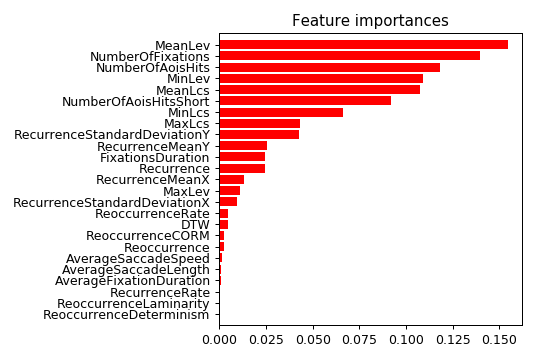

In [350]:
%matplotlib notebook
fu = featureImportance(X,labels_kmedoids,df_dropped_columns, 1)
#dlzka, trvanie a rychlost sakad ako crty pridat

In [118]:
def get_filtered_features(model, features):
    arr = model.get_support()
    for i in range(len(arr)):
        if(arr[i] == False):
            print(features[i])

In [44]:
model = SelectFromModel(fu, prefit=True)
X_new = model.transform(X)
X_new.shape


(45, 8)

In [122]:
get_filtered_features(model, df_.columns)

AverageFixationDuration
AverageSaccadeLength
AverageSaccadeSpeed
MaxLev
NumberOfAoisHits
NumberOfFixations
RecurrenceMeanX
RecurrenceRate
RecurrenceStandardDeviationX
RecurrenceStandardDeviationY
Reoccurrence
ReoccurrenceCORM
ReoccurrenceDeterminism
ReoccurrenceLaminarity
ReoccurrenceRate


0 AverageFixationDuration
1 AverageSaccadeLength
2 AverageSaccadeSpeed
3 DTW
4 FixationsDuration
5 MaxLcs
6 MaxLev
7 MeanLcs
8 MeanLev
9 MinLcs
10 MinLev
11 NumberOfAoisHits
12 NumberOfAoisHitsShort
13 NumberOfFixations
14 Recurrence
15 RecurrenceMeanX
16 RecurrenceMeanY
17 RecurrenceRate
18 RecurrenceStandardDeviationX
19 RecurrenceStandardDeviationY
20 Reoccurrence
21 ReoccurrenceCORM
22 ReoccurrenceDeterminism
23 ReoccurrenceLaminarity
24 ReoccurrenceRate


<IPython.core.display.Javascript object>


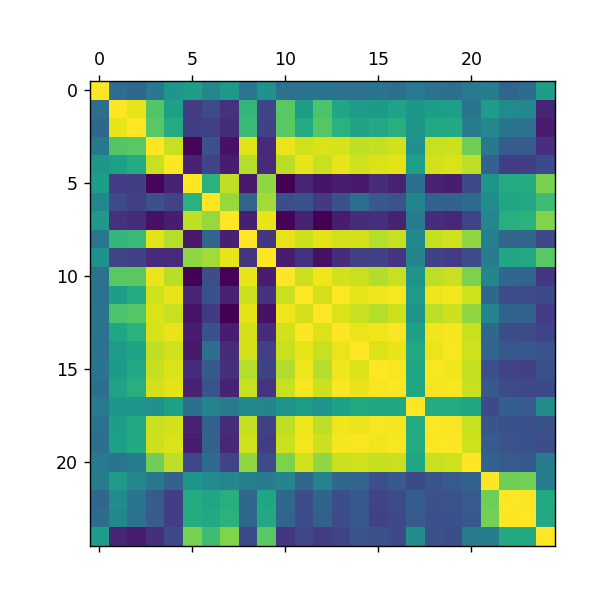

In [180]:
for i in range(0, len(df_.columns)):
    print(str(i) + " " + df_.columns[i])
    i += 1
    
plt.matshow(pd.DataFrame(df_final).corr())

In [176]:
sel = VarianceThreshold(threshold=0.7)
final = sel.fit_transform(df_final)

In [177]:
final.shape

(46, 19)

In [49]:
u = [1,2,3,4]
v = [2,4,6,8]

In [50]:
minkowski(u,v)

5.477225575051661

In [51]:
correlation(u,v)

0.0